In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

# 1. Images Metadata

In [2]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"

# 테스트 데이터의 경로와 정보를 가진 파일의 경로를 설정
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"

In [4]:
import os
os.chdir('/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20')

In [5]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기
train_data = pd.read_csv(traindata_info_file)

# 테스트 데이터
test_data = pd.read_csv(testdata_info_file)

In [6]:
# 학습 데이터의 정보를 출력
train_info = train_data.info()
train_head = train_data.head()

train_info, train_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  15021 non-null  object
 1   image_path  15021 non-null  object
 2   target      15021 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 352.2+ KB


(None,
   class_name                image_path  target
 0  n01872401  n01872401/sketch_50.JPEG      59
 1  n02417914  n02417914/sketch_11.JPEG     202
 2  n02106166   n02106166/sketch_3.JPEG     138
 3  n04235860   n04235860/sketch_2.JPEG     382
 4  n02056570  n02056570/sketch_40.JPEG      80)

주어진 학습 데이터셋은 15021개의 항목과 3개의 컬럼으로 구성되어 있다.
1. class_name: 클래스 이름, string
2. image_path: 이미지 파일의 경로, string
3. target: 클래스를 의미하는 숫자아이디, integer

In [13]:
# 테스트 데이터의 정보를 출력.
test_info = test_data.info()
test_head = test_data.head()

test_info, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10014 non-null  object
dtypes: object(1)
memory usage: 78.4+ KB


(None,
   image_path
 0     0.JPEG
 1     1.JPEG
 2     2.JPEG
 3     3.JPEG
 4     4.JPEG)

주어진 테스트 데이터셋은 10014개의 항목과 1개의 컬럼으로 구성되어 있다.
1. image_path: 이미지 파일의 경로, string

In [14]:
# 데이터의 기본적인 통계 정보를 출력
data_description = train_data.describe(include='all')

# class_name의 unique한 값의 개수를 출력
unique_classes = train_data['class_name'].nunique()

# target의 unique한 값의 개수를 출력
unique_targets = train_data['target'].nunique()

data_description, unique_classes, unique_targets

(       class_name                image_path        target
 count       15021                     15021  15021.000000
 unique        500                     15021           NaN
 top     n04532106  n01872401/sketch_50.JPEG           NaN
 freq           31                         1           NaN
 mean          NaN                       NaN    249.989082
 std           NaN                       NaN    144.471752
 min           NaN                       NaN      0.000000
 25%           NaN                       NaN    125.000000
 50%           NaN                       NaN    250.000000
 75%           NaN                       NaN    375.000000
 max           NaN                       NaN    499.000000,
 500,
 500)

In [7]:
imagenet_cls_map = {'n02119789': 'kit fox, Vulpes macrotis', 'n02100735': 'English setter', 'n02096294': 'Australian terrier', 'n02066245': 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus', 'n02509815': 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'n02124075': 'Egyptian cat', 'n02417914': 'ibex, Capra ibex', 'n02123394': 'Persian cat', 'n02125311': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'n02423022': 'gazelle', 'n02346627': 'porcupine, hedgehog', 'n02077923': 'sea lion', 'n02447366': 'badger', 'n02109047': 'Great Dane', 'n02092002': 'Scottish deerhound, deerhound', 'n02071294': 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'n02442845': 'mink', 'n02504458': 'African elephant, Loxodonta africana', 'n02114712': 'red wolf, maned wolf, Canis rufus, Canis niger', 'n02128925': 'jaguar, panther, Panthera onca, Felis onca', 'n02117135': 'hyena, hyaena', 'n02493509': 'titi, titi monkey', 'n02457408': 'three-toed sloth, ai, Bradypus tridactylus', 'n02389026': 'sorrel', 'n02443484': 'black-footed ferret, ferret, Mustela nigripes', 'n02110341': 'dalmatian, coach dog, carriage dog', 'n02093256': 'Staffordshire bullterrier, Staffordshire bull terrier', 'n02106382': 'Bouvier des Flandres, Bouviers des Flandres', 'n02441942': 'weasel', 'n02113712': 'miniature poodle', 'n02415577': 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'n02356798': 'fox squirrel, eastern fox squirrel, Sciurus niger', 'n02488702': 'colobus, colobus monkey', 'n02123159': 'tiger cat', 'n02422699': 'impala, Aepyceros melampus', 'n02114855': 'coyote, prairie wolf, brush wolf, Canis latrans', 'n02094433': 'Yorkshire terrier', 'n02111277': 'Newfoundland, Newfoundland dog', 'n02119022': 'red fox, Vulpes vulpes', 'n02422106': 'hartebeest', 'n02120505': 'grey fox, gray fox, Urocyon cinereoargenteus', 'n02086079': 'Pekinese, Pekingese, Peke', 'n02484975': 'guenon, guenon monkey', 'n02137549': 'mongoose', 'n02500267': 'indri, indris, Indri indri, Indri brevicaudatus', 'n02129604': 'tiger, Panthera tigris', 'n02396427': 'wild boar, boar, Sus scrofa', 'n02391049': 'zebra', 'n02412080': 'ram, tup', 'n02480495': 'orangutan, orang, orangutang, Pongo pygmaeus', 'n02110806': 'basenji', 'n02128385': 'leopard, Panthera pardus', 'n02100583': 'vizsla, Hungarian pointer', 'n02494079': 'squirrel monkey, Saimiri sciureus', 'n02123597': 'Siamese cat, Siamese', 'n02481823': 'chimpanzee, chimp, Pan troglodytes', 'n02105505': 'komondor', 'n02489166': 'proboscis monkey, Nasalis larvatus', 'n02364673': 'guinea pig, Cavia cobaya', 'n02114548': 'white wolf, Arctic wolf, Canis lupus tundrarum', 'n02134084': 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 'n02480855': 'gorilla, Gorilla gorilla', 'n02403003': 'ox', 'n02108551': 'Tibetan mastiff', 'n02493793': 'spider monkey, Ateles geoffroyi', 'n02107142': 'Doberman, Doberman pinscher', 'n02397096': 'warthog', 'n02437312': 'Arabian camel, dromedary, Camelus dromedarius', 'n02483708': 'siamang, Hylobates syndactylus, Symphalangus syndactylus', 'n02099601': 'golden retriever', 'n02106166': 'Border collie', 'n02326432': 'hare', 'n02108089': 'boxer', 'n02486261': 'patas, hussar monkey, Erythrocebus patas', 'n02486410': 'baboon', 'n02487347': 'macaque', 'n02492035': 'capuchin, ringtail, Cebus capucinus', 'n02099267': 'flat-coated retriever', 'n02395406': 'hog, pig, grunter, squealer, Sus scrofa', 'n02109961': 'Eskimo dog, husky', 'n02101388': 'Brittany spaniel', 'n03187595': 'dial telephone, dial phone', 'n03733281': 'maze, labyrinth', 'n02101006': 'Gordon setter', 'n02115641': 'dingo, warrigal, warragal, Canis dingo', 'n02342885': 'hamster', 'n02120079': 'Arctic fox, white fox, Alopex lagopus', 'n02408429': 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'n02133161': 'American black bear, black bear, Ursus americanus, Euarctos americanus', 'n02328150': 'Angora, Angora rabbit', 'n02410509': 'bison', 'n02492660': 'howler monkey, howler', 'n02398521': 'hippopotamus, hippo, river horse, Hippopotamus amphibius', 'n02510455': 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca', 'n02123045': 'tabby, tabby cat', 'n02490219': 'marmoset', 'n02109525': 'Saint Bernard, St Bernard', 'n02454379': 'armadillo', 'n02090379': 'redbone', 'n02443114': 'polecat, fitch, foulmart, foumart, Mustela putorius', 'n02361337': 'marmot', 'n02483362': 'gibbon, Hylobates lar', 'n02437616': 'llama', 'n02325366': 'wood rabbit, cottontail, cottontail rabbit', 'n02129165': 'lion, king of beasts, Panthera leo', 'n02100877': 'Irish setter, red setter', 'n02074367': 'dugong, Dugong dugon', 'n02504013': 'Indian elephant, Elephas maximus', 'n02363005': 'beaver', 'n02497673': 'Madagascar cat, ring-tailed lemur, Lemur catta', 'n02087394': 'Rhodesian ridgeback', 'n02127052': 'lynx, catamount', 'n02116738': 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus', 'n02488291': 'langur', 'n02114367': 'timber wolf, grey wolf, gray wolf, Canis lupus', 'n02130308': 'cheetah, chetah, Acinonyx jubatus', 'n02134418': 'sloth bear, Melursus ursinus, Ursus ursinus', 'n02106662': 'German shepherd, German shepherd dog, German police dog, alsatian', 'n02444819': 'otter', 'n01882714': 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'n01871265': 'tusker', 'n01872401': 'echidna, spiny anteater, anteater', 'n01877812': 'wallaby, brush kangaroo', 'n01873310': 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus', 'n01883070': 'wombat', 'n04086273': 'revolver, six-gun, six-shooter', 'n04507155': 'umbrella', 'n04147183': 'schooner', 'n04254680': 'soccer ball', 'n02672831': 'accordion, piano accordion, squeeze box', 'n02219486': 'ant, emmet, pismire', 'n02317335': 'starfish, sea star', 'n01968897': 'chambered nautilus, pearly nautilus, nautilus', 'n03452741': 'grand piano, grand', 'n03642806': 'laptop, laptop computer', 'n07745940': 'strawberry', 'n02690373': 'airliner', 'n04552348': 'warplane, military plane', 'n02692877': 'airship, dirigible', 'n02782093': 'balloon', 'n04266014': 'space shuttle', 'n03344393': 'fireboat', 'n03447447': 'gondola', 'n04273569': 'speedboat', 'n03662601': 'lifeboat', 'n02951358': 'canoe', 'n04612504': 'yawl', 'n02981792': 'catamaran', 'n04483307': 'trimaran', 'n03095699': 'container ship, containership, container vessel', 'n03673027': 'liner, ocean liner', 'n03947888': 'pirate, pirate ship', 'n02687172': 'aircraft carrier, carrier, flattop, attack aircraft carrier', 'n04347754': 'submarine, pigboat, sub, U-boat', 'n04606251': 'wreck', 'n03478589': 'half track', 'n04389033': 'tank, army tank, armored combat vehicle, armoured combat vehicle', 'n03773504': 'missile', 'n02860847': 'bobsled, bobsleigh, bob', 'n03218198': 'dogsled, dog sled, dog sleigh', 'n02835271': 'bicycle-built-for-two, tandem bicycle, tandem', 'n03792782': 'mountain bike, all-terrain bike, off-roader', 'n03393912': 'freight car', 'n03895866': 'passenger car, coach, carriage', 'n02797295': 'barrow, garden cart, lawn cart, wheelbarrow', 'n04204347': 'shopping cart', 'n03791053': 'motor scooter, scooter', 'n03384352': 'forklift', 'n03272562': 'electric locomotive', 'n04310018': 'steam locomotive', 'n02704792': 'amphibian, amphibious vehicle', 'n02701002': 'ambulance', 'n02814533': 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'n02930766': 'cab, hack, taxi, taxicab', 'n03100240': 'convertible', 'n03594945': 'jeep, landrover', 'n03670208': 'limousine, limo', 'n03770679': 'minivan', 'n03777568': 'Model T', 'n04037443': 'racer, race car, racing car', 'n04285008': 'sports car, sport car', 'n03444034': 'go-kart', 'n03445924': 'golfcart, golf cart', 'n03785016': 'moped', 'n04252225': 'snowplow, snowplough', 'n03345487': 'fire engine, fire truck', 'n03417042': 'garbage truck, dustcart', 'n03930630': 'pickup, pickup truck', 'n04461696': 'tow truck, tow car, wrecker', 'n04467665': 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi', 'n03796401': 'moving van', 'n03977966': 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'n04065272': 'recreational vehicle, RV, R.V.', 'n04335435': 'streetcar, tram, tramcar, trolley, trolley car', 'n04252077': 'snowmobile', 'n04465501': 'tractor', 'n03776460': 'mobile home, manufactured home', 'n04482393': 'tricycle, trike, velocipede', 'n04509417': 'unicycle, monocycle', 'n03538406': 'horse cart, horse-cart', 'n03788365': 'mosquito net', 'n03868242': 'oxcart', 'n02804414': 'bassinet', 'n03125729': 'cradle', 'n03131574': 'crib, cot', 'n03388549': 'four-poster', 'n02870880': 'bookcase', 'n03018349': 'china cabinet, china closet', 'n03742115': 'medicine chest, medicine cabinet', 'n03016953': 'chiffonier, commode', 'n04380533': 'table lamp', 'n03337140': 'file, file cabinet, filing cabinet', 'n03902125': 'pay-phone, pay-station', 'n03891251': 'park bench', 'n02791124': 'barber chair', 'n04429376': 'throne', 'n03376595': 'folding chair', 'n04099969': 'rocking chair, rocker', 'n04344873': 'studio couch, day bed', 'n04447861': 'toilet seat', 'n03179701': 'desk', 'n03982430': 'pool table, billiard table, snooker table', 'n03201208': 'dining table, board', 'n03290653': 'entertainment center', 'n04550184': 'wardrobe, closet, press', 'n07742313': 'Granny Smith', 'n07747607': 'orange', 'n07749582': 'lemon', 'n07753113': 'fig', 'n07753275': 'pineapple, ananas', 'n07753592': 'banana', 'n07754684': 'jackfruit, jak, jack', 'n07760859': 'custard apple', 'n07768694': 'pomegranate', 'n12267677': 'acorn', 'n12620546': 'hip, rose hip, rosehip', 'n13133613': 'ear, spike, capitulum', 'n11879895': 'rapeseed', 'n12144580': 'corn', 'n12768682': 'buckeye, horse chestnut, conker', 'n03854065': 'organ, pipe organ', 'n04515003': 'upright, upright piano', 'n03017168': 'chime, bell, gong', 'n03249569': 'drum, membranophone, tympan', 'n03447721': 'gong, tam-tam', 'n03720891': 'maraca', 'n03721384': 'marimba, xylophone', 'n04311174': 'steel drum', 'n02787622': 'banjo', 'n02992211': 'cello, violoncello', 'n03637318': 'lampshade, lamp shade', 'n03495258': 'harp', 'n02676566': 'acoustic guitar', 'n03272010': 'electric guitar', 'n03110669': 'cornet, horn, trumpet, trump', 'n03394916': 'French horn, horn', 'n04487394': 'trombone', 'n03494278': 'harmonica, mouth organ, harp, mouth harp', 'n03840681': 'ocarina, sweet potato', 'n03884397': 'panpipe, pandean pipe, syrinx', 'n02804610': 'bassoon', 'n04141076': 'sax, saxophone', 'n03372029': 'flute, transverse flute', 'n11939491': 'daisy', 'n12057211': "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum", 'n09246464': 'cliff, drop, drop-off', 'n09468604': 'valley, vale', 'n09193705': 'alp', 'n09472597': 'volcano', 'n09399592': 'promontory, headland, head, foreland', 'n09421951': 'sandbar, sand bar', 'n09256479': 'coral reef', 'n09332890': 'lakeside, lakeshore', 'n09428293': 'seashore, coast, seacoast, sea-coast', 'n09288635': 'geyser', 'n03498962': 'hatchet', 'n03041632': 'cleaver, meat cleaver, chopper', 'n03658185': 'letter opener, paper knife, paperknife', 'n03954731': "plane, carpenter's plane, woodworking plane", 'n03995372': 'power drill', 'n03649909': 'lawn mower, mower', 'n03481172': 'hammer', 'n03109150': 'corkscrew, bottle screw', 'n02951585': 'can opener, tin opener', 'n03970156': "plunger, plumber's helper", 'n04154565': 'screwdriver', 'n04208210': 'shovel', 'n03967562': 'plow, plough', 'n03000684': 'chain saw, chainsaw', 'n01514668': 'cock', 'n01514859': 'hen', 'n01518878': 'ostrich, Struthio camelus', 'n01530575': 'brambling, Fringilla montifringilla', 'n01531178': 'goldfinch, Carduelis carduelis', 'n01532829': 'house finch, linnet, Carpodacus mexicanus', 'n01534433': 'junco, snowbird', 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'n01558993': 'robin, American robin, Turdus migratorius', 'n01560419': 'bulbul', 'n01580077': 'jay', 'n01582220': 'magpie', 'n01592084': 'chickadee', 'n01601694': 'water ouzel, dipper', 'n01608432': 'kite', 'n01614925': 'bald eagle, American eagle, Haliaeetus leucocephalus', 'n01616318': 'vulture', 'n01622779': 'great grey owl, great gray owl, Strix nebulosa', 'n01795545': 'black grouse', 'n01796340': 'ptarmigan', 'n01797886': 'ruffed grouse, partridge, Bonasa umbellus', 'n01798484': 'prairie chicken, prairie grouse, prairie fowl', 'n01806143': 'peacock', 'n01806567': 'quail', 'n01807496': 'partridge', 'n01817953': 'African grey, African gray, Psittacus erithacus', 'n01818515': 'macaw', 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'n01820546': 'lorikeet', 'n01824575': 'coucal', 'n01828970': 'bee eater', 'n01829413': 'hornbill', 'n01833805': 'hummingbird', 'n01843065': 'jacamar', 'n01843383': 'toucan', 'n01847000': 'drake', 'n01855032': 'red-breasted merganser, Mergus serrator', 'n01855672': 'goose', 'n01860187': 'black swan, Cygnus atratus', 'n02002556': 'white stork, Ciconia ciconia', 'n02002724': 'black stork, Ciconia nigra', 'n02006656': 'spoonbill', 'n02007558': 'flamingo', 'n02009912': 'American egret, great white heron, Egretta albus', 'n02009229': 'little blue heron, Egretta caerulea', 'n02011460': 'bittern', 'n02012849': 'crane', 'n02013706': 'limpkin, Aramus pictus', 'n02018207': 'American coot, marsh hen, mud hen, water hen, Fulica americana', 'n02018795': 'bustard', 'n02025239': 'ruddy turnstone, Arenaria interpres', 'n02027492': 'red-backed sandpiper, dunlin, Erolia alpina', 'n02028035': 'redshank, Tringa totanus', 'n02033041': 'dowitcher', 'n02037110': 'oystercatcher, oyster catcher', 'n02017213': 'European gallinule, Porphyrio porphyrio', 'n02051845': 'pelican', 'n02056570': 'king penguin, Aptenodytes patagonica', 'n02058221': 'albatross, mollymawk', 'n01484850': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361': 'tiger shark, Galeocerdo cuvieri', 'n01494475': 'hammerhead, hammerhead shark', 'n01496331': 'electric ray, crampfish, numbfish, torpedo', 'n01498041': 'stingray', 'n02514041': 'barracouta, snoek', 'n02536864': 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', 'n01440764': 'tench, Tinca tinca', 'n01443537': 'goldfish, Carassius auratus', 'n02526121': 'eel', 'n02606052': 'rock beauty, Holocanthus tricolor', 'n02607072': 'anemone fish', 'n02643566': 'lionfish', 'n02655020': 'puffer, pufferfish, blowfish, globefish', 'n02640242': 'sturgeon', 'n02641379': 'gar, garfish, garpike, billfish, Lepisosteus osseus', 'n01664065': 'loggerhead, loggerhead turtle, Caretta caretta', 'n01667114': 'mud turtle', 'n01667778': 'terrapin', 'n01669191': 'box turtle, box tortoise', 'n01675722': 'banded gecko', 'n01677366': 'common iguana, iguana, Iguana iguana', 'n01682714': 'American chameleon, anole, Anolis carolinensis', 'n01685808': 'whiptail, whiptail lizard', 'n01687978': 'agama', 'n01688243': 'frilled lizard, Chlamydosaurus kingi', 'n01689811': 'alligator lizard', 'n01692333': 'Gila monster, Heloderma suspectum', 'n01693334': 'green lizard, Lacerta viridis', 'n01694178': 'African chameleon, Chamaeleo chamaeleon', 'n01695060': 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'n01704323': 'triceratops', 'n01697457': 'African crocodile, Nile crocodile, Crocodylus niloticus', 'n01698640': 'American alligator, Alligator mississipiensis', 'n01728572': 'thunder snake, worm snake, Carphophis amoenus', 'n01728920': 'ringneck snake, ring-necked snake, ring snake', 'n01729322': 'hognose snake, puff adder, sand viper', 'n01729977': 'green snake, grass snake', 'n01734418': 'king snake, kingsnake', 'n01735189': 'garter snake, grass snake', 'n01737021': 'water snake', 'n01739381': 'vine snake', 'n01740131': 'night snake, Hypsiglena torquata', 'n01742172': 'boa constrictor, Constrictor constrictor', 'n01744401': 'rock python, rock snake, Python sebae', 'n01748264': 'Indian cobra, Naja naja', 'n01749939': 'green mamba', 'n01751748': 'sea snake', 'n01753488': 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'n04326547': 'stone wall', 'n01756291': 'sidewinder, horned rattlesnake, Crotalus cerastes', 'n01629819': 'European fire salamander, Salamandra salamandra', 'n01630670': 'common newt, Triturus vulgaris', 'n01631663': 'eft', 'n01632458': 'spotted salamander, Ambystoma maculatum', 'n01632777': 'axolotl, mud puppy, Ambystoma mexicanum', 'n01641577': 'bullfrog, Rana catesbeiana', 'n01644373': 'tree frog, tree-frog', 'n01644900': 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'n04579432': 'whistle', 'n04592741': 'wing', 'n03876231': 'paintbrush', 'n03868863': 'oxygen mask', 'n04251144': 'snorkel', 'n03691459': 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system', 'n03759954': 'microphone, mike', 'n04152593': 'screen, CRT screen', 'n03793489': 'mouse, computer mouse', 'n03271574': 'electric fan, blower', 'n03843555': 'oil filter', 'n04332243': 'strainer', 'n04265275': 'space heater', 'n04330267': 'stove', 'n03467068': 'guillotine', 'n02794156': 'barometer', 'n04118776': 'rule, ruler', 'n03841143': 'odometer, hodometer, mileometer, milometer', 'n04141975': 'scale, weighing machine', 'n02708093': 'analog clock', 'n03196217': 'digital clock', 'n04548280': 'wall clock', 'n03544143': 'hourglass', 'n04355338': 'sundial', 'n03891332': 'parking meter', 'n04328186': 'stopwatch, stop watch', 'n03197337': 'digital watch', 'n04317175': 'stethoscope', 'n04376876': 'syringe', 'n03706229': 'magnetic compass', 'n02841315': 'binoculars, field glasses, opera glasses', 'n04009552': 'projector', 'n04356056': 'sunglasses, dark glasses, shades', 'n03692522': "loupe, jeweler's loupe", 'n04044716': 'radio telescope, radio reflector', 'n02879718': 'bow', 'n02950826': 'cannon', 'n02749479': 'assault rifle, assault gun', 'n04090263': 'rifle', 'n04008634': 'projectile, missile', 'n03085013': 'computer keyboard, keypad', 'n04505470': 'typewriter keyboard', 'n03126707': 'crane', 'n03666591': 'lighter, light, igniter, ignitor', 'n02666196': 'abacus', 'n02977058': 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'n04238763': 'slide rule, slipstick', 'n03180011': 'desktop computer', 'n03485407': 'hand-held computer, hand-held microcomputer', 'n03832673': 'notebook, notebook computer', 'n03874599': 'padlock', 'n03496892': 'harvester, reaper', 'n04428191': 'thresher, thrasher, threshing machine', 'n04004767': 'printer', 'n04243546': 'slot, one-armed bandit', 'n04525305': 'vending machine', 'n04179913': 'sewing machine', 'n03602883': 'joystick', 'n04372370': 'switch, electric switch, electrical switch', 'n03532672': 'hook, claw', 'n02974003': 'car wheel', 'n03874293': 'paddlewheel, paddle wheel', 'n03944341': 'pinwheel', 'n03992509': "potter's wheel", 'n03425413': 'gas pump, gasoline pump, petrol pump, island dispenser', 'n02966193': 'carousel, carrousel, merry-go-round, roundabout, whirligig', 'n04371774': 'swing', 'n04067472': 'reel', 'n04040759': 'radiator', 'n04019541': 'puck, hockey puck', 'n03492542': 'hard disc, hard disk, fixed disk', 'n04355933': 'sunglass', 'n03929660': 'pick, plectrum, plectron', 'n02965783': 'car mirror', 'n04258138': 'solar dish, solar collector, solar furnace', 'n04074963': 'remote control, remote', 'n03208938': 'disk brake, disc brake', 'n02910353': 'buckle', 'n03476684': 'hair slide', 'n03627232': 'knot', 'n03075370': 'combination lock', 'n06359193': 'web site, website, internet site, site', 'n03804744': 'nail', 'n04127249': 'safety pin', 'n04153751': 'screw', 'n03803284': 'muzzle', 'n04162706': 'seat belt, seatbelt', 'n04228054': 'ski', 'n02948072': 'candle, taper, wax light', 'n03590841': "jack-o'-lantern", 'n04286575': 'spotlight, spot', 'n04456115': 'torch', 'n03814639': 'neck brace', 'n03933933': 'pier', 'n04485082': 'tripod', 'n03733131': 'maypole', 'n03483316': 'hand blower, blow dryer, blow drier, hair dryer, hair drier', 'n03794056': 'mousetrap', 'n04275548': "spider web, spider's web", 'n01768244': 'trilobite', 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio', 'n01770393': 'scorpion', 'n01773157': 'black and gold garden spider, Argiope aurantia', 'n01773549': 'barn spider, Araneus cavaticus', 'n01773797': 'garden spider, Aranea diademata', 'n01774384': 'black widow, Latrodectus mactans', 'n01774750': 'tarantula', 'n01775062': 'wolf spider, hunting spider', 'n01776313': 'tick', 'n01784675': 'centipede', 'n01990800': 'isopod', 'n01978287': 'Dungeness crab, Cancer magister', 'n01978455': 'rock crab, Cancer irroratus', 'n01980166': 'fiddler crab', 'n01981276': 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica', 'n01983481': 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'n01985128': 'crayfish, crawfish, crawdad, crawdaddy', 'n01986214': 'hermit crab', 'n02165105': 'tiger beetle', 'n02165456': 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'n02167151': 'ground beetle, carabid beetle', 'n02168699': 'long-horned beetle, longicorn, longicorn beetle', 'n02169497': 'leaf beetle, chrysomelid', 'n02172182': 'dung beetle', 'n02174001': 'rhinoceros beetle', 'n02177972': 'weevil', 'n02190166': 'fly', 'n02206856': 'bee', 'n02226429': 'grasshopper, hopper', 'n02229544': 'cricket', 'n02231487': 'walking stick, walkingstick, stick insect', 'n02233338': 'cockroach, roach', 'n02236044': 'mantis, mantid', 'n02256656': 'cicada, cicala', 'n02259212': 'leafhopper', 'n02264363': 'lacewing, lacewing fly', 'n02268443': "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'n02268853': 'damselfly', 'n02276258': 'admiral', 'n02277742': 'ringlet, ringlet butterfly', 'n02279972': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'n02280649': 'cabbage butterfly', 'n02281406': 'sulphur butterfly, sulfur butterfly', 'n02281787': 'lycaenid, lycaenid butterfly', 'n01910747': 'jellyfish', 'n01914609': 'sea anemone, anemone', 'n01917289': 'brain coral', 'n01924916': 'flatworm, platyhelminth', 'n01930112': 'nematode, nematode worm, roundworm', 'n01943899': 'conch', 'n01944390': 'snail', 'n01945685': 'slug', 'n01950731': 'sea slug, nudibranch', 'n01955084': 'chiton, coat-of-mail shell, sea cradle, polyplacophore', 'n02319095': 'sea urchin', 'n02321529': 'sea cucumber, holothurian', 'n03584829': 'iron, smoothing iron', 'n03297495': 'espresso maker', 'n03761084': 'microwave, microwave oven', 'n03259280': 'Dutch oven', 'n04111531': 'rotisserie', 'n04442312': 'toaster', 'n04542943': 'waffle iron', 'n04517823': 'vacuum, vacuum cleaner', 'n03207941': 'dishwasher, dish washer, dishwashing machine', 'n04070727': 'refrigerator, icebox', 'n04554684': 'washer, automatic washer, washing machine', 'n03133878': 'Crock Pot', 'n03400231': 'frying pan, frypan, skillet', 'n04596742': 'wok', 'n02939185': 'caldron, cauldron', 'n03063689': 'coffeepot', 'n04398044': 'teapot', 'n04270147': 'spatula', 'n02699494': 'altar', 'n04486054': 'triumphal arch', 'n03899768': 'patio, terrace', 'n04311004': 'steel arch bridge', 'n04366367': 'suspension bridge', 'n04532670': 'viaduct', 'n02793495': 'barn', 'n03457902': 'greenhouse, nursery, glasshouse', 'n03877845': 'palace', 'n03781244': 'monastery', 'n03661043': 'library', 'n02727426': 'apiary, bee house', 'n02859443': 'boathouse', 'n03028079': 'church, church building', 'n03788195': 'mosque', 'n04346328': 'stupa, tope', 'n03956157': 'planetarium', 'n04081281': 'restaurant, eating house, eating place, eatery', 'n03032252': 'cinema, movie theater, movie theatre, movie house, picture palace', 'n03529860': 'home theater, home theatre', 'n03697007': 'lumbermill, sawmill', 'n03065424': 'coil, spiral, volute, whorl, helix', 'n03837869': 'obelisk', 'n04458633': 'totem pole', 'n02980441': 'castle', 'n04005630': 'prison, prison house', 'n03461385': 'grocery store, grocery, food market, market', 'n02776631': 'bakery, bakeshop, bakehouse', 'n02791270': 'barbershop', 'n02871525': 'bookshop, bookstore, bookstall', 'n02927161': 'butcher shop, meat market', 'n03089624': 'confectionery, confectionary, candy store', 'n04200800': 'shoe shop, shoe-shop, shoe store', 'n04443257': 'tobacco shop, tobacconist shop, tobacconist', 'n04462240': 'toyshop', 'n03388043': 'fountain', 'n03042490': 'cliff dwelling', 'n04613696': 'yurt', 'n03216828': 'dock, dockage, docking facility', 'n02892201': 'brass, memorial tablet, plaque', 'n03743016': 'megalith, megalithic structure', 'n02788148': 'bannister, banister, balustrade, balusters, handrail', 'n02894605': 'breakwater, groin, groyne, mole, bulwark, seawall, jetty', 'n03160309': 'dam, dike, dyke', 'n03000134': 'chainlink fence', 'n03930313': 'picket fence, paling', 'n04604644': 'worm fence, snake fence, snake-rail fence, Virginia fence', 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus', 'n03459775': 'grille, radiator grille', 'n04239074': 'sliding door', 'n04501370': 'turnstile', 'n03792972': 'mountain tent', 'n04149813': 'scoreboard', 'n03530642': 'honeycomb', 'n03961711': 'plate rack', 'n03903868': 'pedestal, plinth, footstall', 'n02814860': 'beacon, lighthouse, beacon light, pharos', 'n01665541': 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 'n07711569': 'mashed potato', 'n07720875': 'bell pepper', 'n07714571': 'head cabbage', 'n07714990': 'broccoli', 'n07715103': 'cauliflower', 'n07716358': 'zucchini, courgette', 'n07716906': 'spaghetti squash', 'n07717410': 'acorn squash', 'n07717556': 'butternut squash', 'n07718472': 'cucumber, cuke', 'n07718747': 'artichoke, globe artichoke', 'n07730033': 'cardoon', 'n07734744': 'mushroom', 'n04209239': 'shower curtain', 'n03594734': 'jean, blue jean, denim', 'n02971356': 'carton', 'n03485794': 'handkerchief, hankie, hanky, hankey', 'n04133789': 'sandal', 'n02747177': 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin', 'n04125021': 'safe', 'n07579787': 'plate', 'n03814906': 'necklace', 'n03134739': 'croquet ball', 'n03404251': 'fur coat', 'n04423845': 'thimble', 'n03877472': "pajama, pyjama, pj's, jammies", 'n04120489': 'running shoe', 'n03838899': 'oboe, hautboy, hautbois', 'n03062245': 'cocktail shaker', 'n03014705': 'chest', 'n03717622': 'manhole cover', 'n03777754': 'modem', 'n04493381': 'tub, vat', 'n04476259': 'tray', 'n02777292': 'balance beam, beam', 'n07693725': 'bagel, beigel', 'n04536866': 'violin, fiddle', 'n03998194': 'prayer rug, prayer mat', 'n03617480': 'kimono', 'n07590611': 'hot pot, hotpot', 'n04579145': 'whiskey jug', 'n03623198': 'knee pad', 'n07248320': 'book jacket, dust cover, dust jacket, dust wrapper', 'n04277352': 'spindle', 'n04229816': 'ski mask', 'n02823428': 'beer bottle', 'n03127747': 'crash helmet', 'n02877765': 'bottlecap', 'n04435653': 'tile roof', 'n03724870': 'mask', 'n03710637': 'maillot', 'n03920288': 'Petri dish', 'n03379051': 'football helmet', 'n02807133': 'bathing cap, swimming cap', 'n04399382': 'teddy, teddy bear', 'n03527444': 'holster', 'n03983396': 'pop bottle, soda bottle', 'n03924679': 'photocopier', 'n04532106': 'vestment', 'n06785654': 'crossword puzzle, crossword', 'n03445777': 'golf ball', 'n07613480': 'trifle', 'n04350905': 'suit, suit of clothes', 'n04562935': 'water tower', 'n03325584': 'feather boa, boa', 'n03045698': 'cloak', 'n07892512': 'red wine', 'n03250847': 'drumstick', 'n04192698': 'shield, buckler', 'n03026506': 'Christmas stocking', 'n03534580': 'hoopskirt, crinoline', 'n07565083': 'menu', 'n04296562': 'stage', 'n02869837': 'bonnet, poke bonnet', 'n07871810': 'meat loaf, meatloaf', 'n02799071': 'baseball', 'n03314780': 'face powder', 'n04141327': 'scabbard', 'n04357314': 'sunscreen, sunblock, sun blocker', 'n02823750': 'beer glass', 'n13052670': 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa', 'n07583066': 'guacamole', 'n04599235': 'wool, woolen, woollen', 'n07802026': 'hay', 'n02883205': 'bow tie, bow-tie, bowtie', 'n03709823': 'mailbag, postbag', 'n04560804': 'water jug', 'n02909870': 'bucket, pail', 'n03207743': 'dishrag, dishcloth', 'n04263257': 'soup bowl', 'n07932039': 'eggnog', 'n03786901': 'mortar', 'n04479046': 'trench coat', 'n03873416': 'paddle, boat paddle', 'n02999410': 'chain', 'n04367480': 'swab, swob, mop', 'n03775546': 'mixing bowl', 'n07875152': 'potpie', 'n04591713': 'wine bottle', 'n04201297': 'shoji', 'n02916936': 'bulletproof vest', 'n03240683': 'drilling platform, offshore rig', 'n02840245': 'binder, ring-binder', 'n02963159': 'cardigan', 'n04370456': 'sweatshirt', 'n03991062': 'pot, flowerpot', 'n02843684': 'birdhouse', 'n03599486': 'jinrikisha, ricksha, rickshaw', 'n03482405': 'hamper', 'n03942813': 'ping-pong ball', 'n03908618': 'pencil box, pencil case', 'n07584110': 'consomme', 'n02730930': 'apron', 'n04023962': 'punching bag, punch bag, punching ball, punchball', 'n02769748': 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'n10148035': 'groom, bridegroom', 'n02817516': 'bearskin, busby, shako', 'n03908714': 'pencil sharpener', 'n02906734': 'broom', 'n02667093': 'abaya', 'n03787032': 'mortarboard', 'n03980874': 'poncho', 'n03141823': 'crutch', 'n03976467': 'Polaroid camera, Polaroid Land camera', 'n04264628': 'space bar', 'n07930864': 'cup', 'n04039381': 'racket, racquet', 'n06874185': 'traffic light, traffic signal, stoplight', 'n04033901': 'quill, quill pen', 'n04041544': 'radio, wireless', 'n02128757': 'snow leopard, ounce, Panthera uncia', 'n07860988': 'dough', 'n03146219': 'cuirass', 'n03763968': 'military uniform', 'n03676483': 'lipstick, lip rouge', 'n04209133': 'shower cap', 'n03782006': 'monitor', 'n03857828': 'oscilloscope, scope, cathode-ray oscilloscope, CRO', 'n03775071': 'mitten', 'n02892767': 'brassiere, bra, bandeau', 'n07684084': 'French loaf', 'n04522168': 'vase', 'n03764736': 'milk can', 'n04118538': 'rugby ball', 'n03887697': 'paper towel', 'n13044778': 'earthstar', 'n03291819': 'envelope', 'n03770439': 'miniskirt, mini', 'n03124170': 'cowboy hat, ten-gallon hat', 'n04487081': 'trolleybus, trolley coach, trackless trolley', 'n03916031': 'perfume, essence', 'n02808440': 'bathtub, bathing tub, bath, tub', 'n07697537': 'hotdog, hot dog, red hot', 'n12985857': 'coral fungus', 'n02917067': 'bullet train, bullet', 'n03938244': 'pillow', 'n15075141': 'toilet tissue, toilet paper, bathroom tissue', 'n02978881': 'cassette', 'n02966687': "carpenter's kit, tool kit", 'n03633091': 'ladle', 'n13040303': 'stinkhorn, carrion fungus', 'n03690938': 'lotion', 'n03476991': 'hair spray', 'n02669723': "academic gown, academic robe, judge's robe", 'n03220513': 'dome', 'n03127925': 'crate', 'n04584207': 'wig', 'n07880968': 'burrito', 'n03937543': 'pill bottle', 'n03000247': 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour', 'n04418357': 'theater curtain, theatre curtain', 'n04590129': 'window shade', 'n02795169': 'barrel, cask', 'n04553703': 'washbasin, handbasin, washbowl, lavabo, wash-hand basin', 'n02783161': 'ballpoint, ballpoint pen, ballpen, Biro', 'n02802426': 'basketball', 'n02808304': 'bath towel', 'n03124043': 'cowboy boot', 'n03450230': 'gown', 'n04589890': 'window screen', 'n12998815': 'agaric', 'n02113799': 'standard poodle', 'n02992529': 'cellular telephone, cellular phone, cellphone, cell, mobile phone', 'n03825788': 'nipple', 'n02790996': 'barbell', 'n03710193': 'mailbox, letter box', 'n03630383': 'lab coat, laboratory coat', 'n03347037': 'fire screen, fireguard', 'n03769881': 'minibus', 'n03871628': 'packet', 'n02132136': 'brown bear, bruin, Ursus arctos', 'n03976657': 'pole', 'n03535780': 'horizontal bar, high bar', 'n04259630': 'sombrero', 'n03929855': 'pickelhaube', 'n04049303': 'rain barrel', 'n04548362': 'wallet, billfold, notecase, pocketbook', 'n02979186': 'cassette player', 'n06596364': 'comic book', 'n03935335': 'piggy bank, penny bank', 'n06794110': 'street sign', 'n02825657': 'bell cote, bell cot', 'n03388183': 'fountain pen', 'n04591157': 'Windsor tie', 'n04540053': 'volleyball', 'n03866082': 'overskirt', 'n04136333': 'sarong', 'n04026417': 'purse', 'n02865351': 'bolo tie, bolo, bola tie, bola', 'n02834397': 'bib', 'n03888257': 'parachute, chute', 'n04235860': 'sleeping bag', 'n04404412': 'television, television system', 'n04371430': 'swimming trunks, bathing trunks', 'n03733805': 'measuring cup', 'n07920052': 'espresso', 'n07873807': 'pizza, pizza pie', 'n02895154': 'breastplate, aegis, egis', 'n04204238': 'shopping basket', 'n04597913': 'wooden spoon', 'n04131690': 'saltshaker, salt shaker', 'n07836838': 'chocolate sauce, chocolate syrup', 'n09835506': 'ballplayer, baseball player', 'n03443371': 'goblet', 'n13037406': 'gyromitra', 'n04336792': 'stretcher', 'n04557648': 'water bottle', 'n02445715': 'skunk, polecat, wood pussy', 'n04254120': 'soap dispenser', 'n03595614': 'jersey, T-shirt, tee shirt', 'n04146614': 'school bus', 'n03598930': 'jigsaw puzzle', 'n03958227': 'plastic bag', 'n04069434': 'reflex camera', 'n03188531': 'diaper, nappy, napkin', 'n02786058': 'Band Aid', 'n07615774': 'ice lolly, lolly, lollipop, popsicle', 'n04525038': 'velvet', 'n04409515': 'tennis ball', 'n03424325': 'gasmask, respirator, gas helmet', 'n03223299': 'doormat, welcome mat', 'n03680355': 'Loafer', 'n07614500': 'ice cream, icecream', 'n07695742': 'pretzel', 'n04033995': 'quilt, comforter, comfort, puff', 'n03710721': 'maillot, tank suit', 'n04392985': 'tape player', 'n03047690': 'clog, geta, patten, sabot', 'n03584254': 'iPod', 'n13054560': 'bolete', 'n02138441': 'meerkat, mierkat', 'n10565667': 'scuba diver', 'n03950228': 'pitcher, ewer', 'n03729826': 'matchstick', 'n02837789': 'bikini, two-piece', 'n04254777': 'sock', 'n02988304': 'CD player', 'n03657121': 'lens cap, lens cover', 'n04417672': 'thatch, thatched roof', 'n04523525': 'vault', 'n02815834': 'beaker', 'n09229709': 'bubble', 'n07697313': 'cheeseburger', 'n03888605': 'parallel bars, bars', 'n03355925': 'flagpole, flagstaff', 'n03063599': 'coffee mug', 'n04116512': 'rubber eraser, rubber, pencil eraser', 'n04325704': 'stole', 'n07831146': 'carbonara', 'n03255030': 'dumbbell', 'n02110185': 'Siberian husky', 'n02102040': 'English springer, English springer spaniel', 'n02110063': 'malamute, malemute, Alaskan malamute', 'n02089867': 'Walker hound, Walker foxhound', 'n02102177': 'Welsh springer spaniel', 'n02091134': 'whippet', 'n02092339': 'Weimaraner', 'n02098105': 'soft-coated wheaten terrier', 'n02096437': 'Dandie Dinmont, Dandie Dinmont terrier', 'n02105641': 'Old English sheepdog, bobtail', 'n02091635': 'otterhound, otter hound', 'n02088466': 'bloodhound, sleuthhound', 'n02096051': 'Airedale, Airedale terrier', 'n02097130': 'giant schnauzer', 'n02089078': 'black-and-tan coonhound', 'n02086910': 'papillon', 'n02113978': 'Mexican hairless', 'n02113186': 'Cardigan, Cardigan Welsh corgi', 'n02105162': 'malinois', 'n02098413': 'Lhasa, Lhasa apso', 'n02091467': 'Norwegian elkhound, elkhound', 'n02106550': 'Rottweiler', 'n02091831': 'Saluki, gazelle hound', 'n02104365': 'schipperke', 'n02112706': 'Brabancon griffon', 'n02098286': 'West Highland white terrier', 'n02095889': 'Sealyham terrier, Sealyham', 'n02090721': 'Irish wolfhound', 'n02108000': 'EntleBucher', 'n02108915': 'French bulldog', 'n02107683': 'Bernese mountain dog', 'n02085936': 'Maltese dog, Maltese terrier, Maltese', 'n02094114': 'Norfolk terrier', 'n02087046': 'toy terrier', 'n02096177': 'cairn, cairn terrier', 'n02105056': 'groenendael', 'n02101556': 'clumber, clumber spaniel', 'n02088094': 'Afghan hound, Afghan', 'n02085782': 'Japanese spaniel', 'n02090622': 'borzoi, Russian wolfhound', 'n02113624': 'toy poodle', 'n02093859': 'Kerry blue terrier', 'n02097298': 'Scotch terrier, Scottish terrier, Scottie', 'n02096585': 'Boston bull, Boston terrier', 'n02107574': 'Greater Swiss Mountain dog', 'n02107908': 'Appenzeller', 'n02086240': 'Shih-Tzu', 'n02102973': 'Irish water spaniel', 'n02112018': 'Pomeranian', 'n02093647': 'Bedlington terrier', 'n02097047': 'miniature schnauzer', 'n02106030': 'collie', 'n02093991': 'Irish terrier', 'n02110627': 'affenpinscher, monkey pinscher, monkey dog', 'n02097658': 'silky terrier, Sydney silky', 'n02088364': 'beagle', 'n02111129': 'Leonberg', 'n02100236': 'German short-haired pointer', 'n02115913': 'dhole, Cuon alpinus', 'n02099849': 'Chesapeake Bay retriever', 'n02108422': 'bull mastiff', 'n02104029': 'kuvasz', 'n02110958': 'pug, pug-dog', 'n02099429': 'curly-coated retriever', 'n02094258': 'Norwich terrier', 'n02112350': 'keeshond', 'n02095570': 'Lakeland terrier', 'n02097209': 'standard schnauzer', 'n02097474': 'Tibetan terrier, chrysanthemum dog', 'n02095314': 'wire-haired fox terrier', 'n02088238': 'basset, basset hound', 'n02112137': 'chow, chow chow', 'n02093428': 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier', 'n02105855': 'Shetland sheepdog, Shetland sheep dog, Shetland', 'n02111500': 'Great Pyrenees', 'n02085620': 'Chihuahua', 'n02099712': 'Labrador retriever', 'n02111889': 'Samoyed, Samoyede', 'n02088632': 'bluetick', 'n02105412': 'kelpie', 'n02107312': 'miniature pinscher', 'n02091032': 'Italian greyhound', 'n02102318': 'cocker spaniel, English cocker spaniel, cocker', 'n02102480': 'Sussex spaniel', 'n02113023': 'Pembroke, Pembroke Welsh corgi', 'n02086646': 'Blenheim spaniel', 'n02091244': 'Ibizan hound, Ibizan Podenco', 'n02089973': 'English foxhound', 'n02105251': 'briard', 'n02093754': 'Border terrier'}

In [8]:
train_data['class_name'].unique()[0]
imagenet_cls_map[train_data['class_name'].unique()[0]]
mini_imagenet_cls_map={}
for name in train_data['class_name'].unique():
    mini_imagenet_cls_map[name] = imagenet_cls_map[name]

mini_imagenet_cls_map
len(mini_imagenet_cls_map)

500

In [9]:
mini_imagenet_cls_map

{'n01872401': 'echidna, spiny anteater, anteater',
 'n02417914': 'ibex, Capra ibex',
 'n02106166': 'Border collie',
 'n04235860': 'sleeping bag',
 'n02056570': 'king penguin, Aptenodytes patagonica',
 'n07734744': 'mushroom',
 'n02098286': 'West Highland white terrier',
 'n02097298': 'Scotch terrier, Scottish terrier, Scottie',
 'n02403003': 'ox',
 'n04456115': 'torch',
 'n02408429': 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 'n09472597': 'volcano',
 'n04004767': 'printer',
 'n03832673': 'notebook, notebook computer',
 'n01748264': 'Indian cobra, Naja naja',
 'n02096437': 'Dandie Dinmont, Dandie Dinmont terrier',
 'n02325366': 'wood rabbit, cottontail, cottontail rabbit',
 'n03857828': 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 'n03481172': 'hammer',
 'n02701002': 'ambulance',
 'n01855032': 'red-breasted merganser, Mergus serrator',
 'n01698640': 'American alligator, Alligator mississipiensis',
 'n02114548': 'white wolf, Arctic wolf, Canis lupus tundrarum

기본 통계
- 데이터셋에는 15,021개의 항목이 있음
- 500개의 고유한 클래스 이름과 15021개의 고유한 이미지 경로가 존재
- Target값은 0에서 499까지 500개의 값을 가지고 있음

/tmp/ipykernel_1339754/1406674816.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')
/tmp/ipykernel_1339754/1406674816.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')


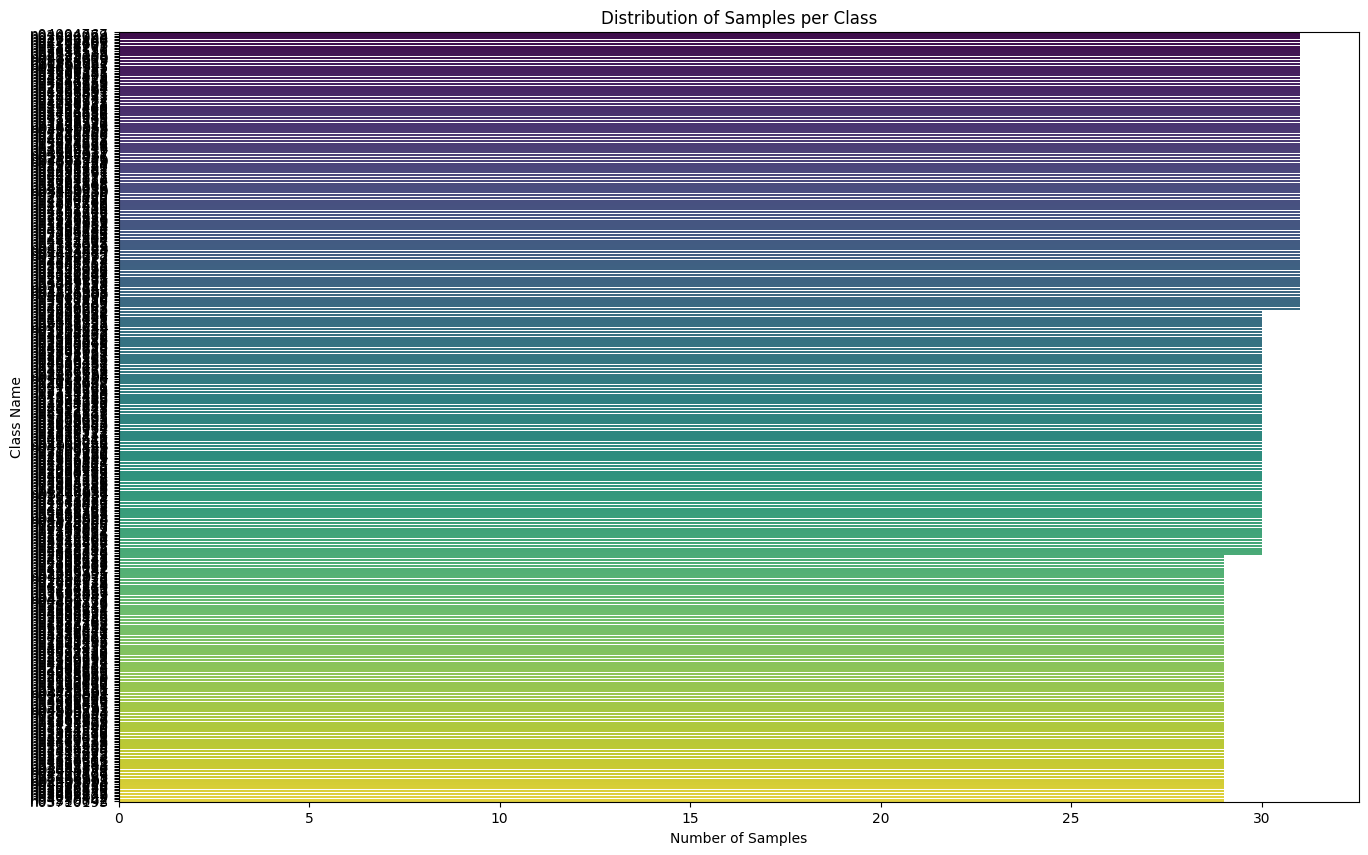

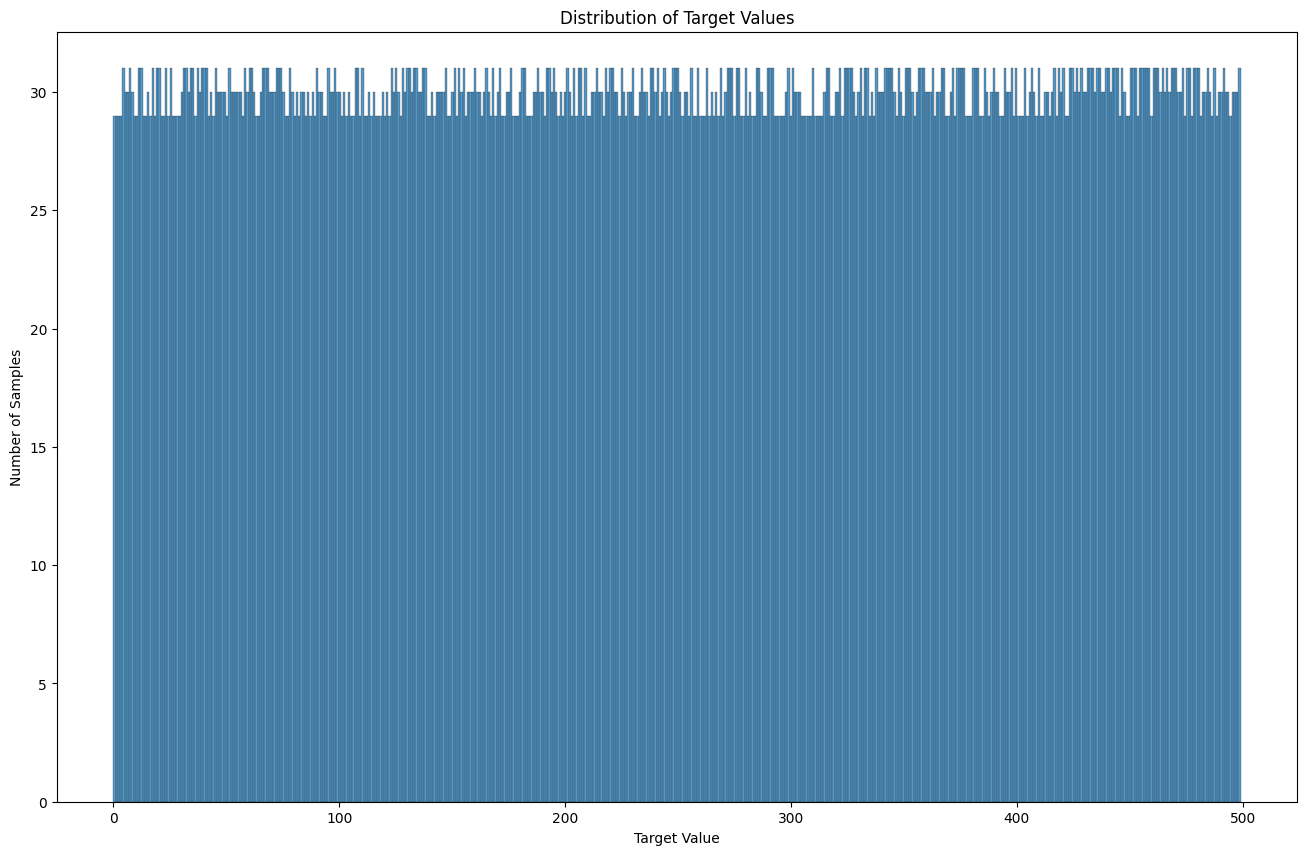

In [10]:
plt.figure(figsize=(16, 10))

# class_name별로 샘플의 개수를 출력
sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class Name')

# target 값의 분포를 출력
plt.figure(figsize=(16, 10))
sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')
plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Number of Samples')

plt.show()


Class name 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

Target 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

데이터 셋 전반적으로 Class name, Target에 대해서 29~31개의 값을 가지고 있음.

# 2. Images - Exploration and processing

In [11]:
# glob을 이용하여 이미지 파일의 경로를 읽어옴
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


## 2.1 Getting Image's statistics

In [12]:
image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    with Image.open(path) as img:
        image_prop['height'].append(img.height)
        image_prop['width'].append(img.width)
        image_prop['img_aspect_ratio'] = img.width / img.height
        image_prop['mode'].append(img.mode)
        image_prop['format'].append(img.format)
        image_prop['size'].append(round(os.path.getsize(path) / 1e6, 2))
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])

image_data = pd.DataFrame(image_prop)

image_data = image_data.merge(train_data, on='image_path')
#image_data.sort_values(by='target', inplace=True)


In [15]:
# 이미지의 특징을 추출하는 함수
def extract_image_features(image_path):
    """
    Extracts features from an image.
    Args:
        image_path (str): Path to the image file.
    Returns:
        width (int): Width of the image.
        height (int): Height of the image.
        mode (str): Mode of the image.
        format (str): Format of the image.
        size (int): Size of the image.
        mean_red (float): Mean of red channel.
        mean_green (float): Mean of green channel.
        mean_blue (float): Mean of blue channel.
    """
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            width, height = img.size
            img_array = np.array(img)
            mean_red = np.mean(img_array[:, :, 0])
            mean_green = np.mean(img_array[:, :, 1])
            mean_blue = np.mean(img_array[:, :, 2])
            format = image_path.split('.')[-1].upper()
            return width, height, img.mode, format, os.path.getsize(image_path), mean_red, mean_green, mean_blue
    except Exception as e:
        return None, None, None, None, None, None, None, None

image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    width, height, mode, format, size, mean_red, mean_green, mean_blue = extract_image_features(path)
    image_prop['height'].append(height)
    image_prop['width'].append(width)
    image_prop['mode'].append(mode)
    image_prop['format'].append(format)
    image_prop['size'].append(round(size / 1e6, 2) if size else None)
    image_prop['mean_red'].append(mean_red)
    image_prop['mean_green'].append(mean_green)
    image_prop['mean_blue'].append(mean_blue)
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])

image_data = pd.DataFrame(image_prop)
image_data['img_aspect_ratio'] = image_data['width'] / image_data['height']

image_data = image_data.merge(train_data, on='image_path')
image_data.sort_values(by='target', inplace=True)


In [16]:
image_data.head()

height  width mode format  size    mean_red  mean_green   mean_blue  \
2638     628    800  RGB   JPEG  0.05  236.068286  236.068286  236.068286   
2645     470    450  RGB   JPEG  0.08  219.883764  219.918085  219.901504   
2644     470    450  RGB   JPEG  0.05  234.881868  234.881868  234.881868   
2647     671    800  RGB   JPEG  0.11  185.432288  185.726542  187.349311   
2646     447    553  RGB   JPEG  0.05  237.306188  236.565138  236.498012   

                                       path                image_path  \
2638  ./data/train/n01443537/sketch_13.JPEG  n01443537/sketch_13.JPEG   
2645  ./data/train/n01443537/sketch_43.JPEG  n01443537/sketch_43.JPEG   
2644   ./data/train/n01443537/sketch_6.JPEG   n01443537/sketch_6.JPEG   
2647  ./data/train/n01443537/sketch_10.JPEG  n01443537/sketch_10.JPEG   
2646   ./data/train/n01443537/sketch_9.JPEG   n01443537/sketch_9.JPEG   

      img_aspect_ratio class_name  target  
2638          1.273885  n01443537       0  
2645          0.957447  n01443537       0  
2644          0.957447  n01443537       0  
2647          1.192250  n01443537       0  
2646          1.237136  n01443537       0

### 2.1.1 이미지 파일크기 분석

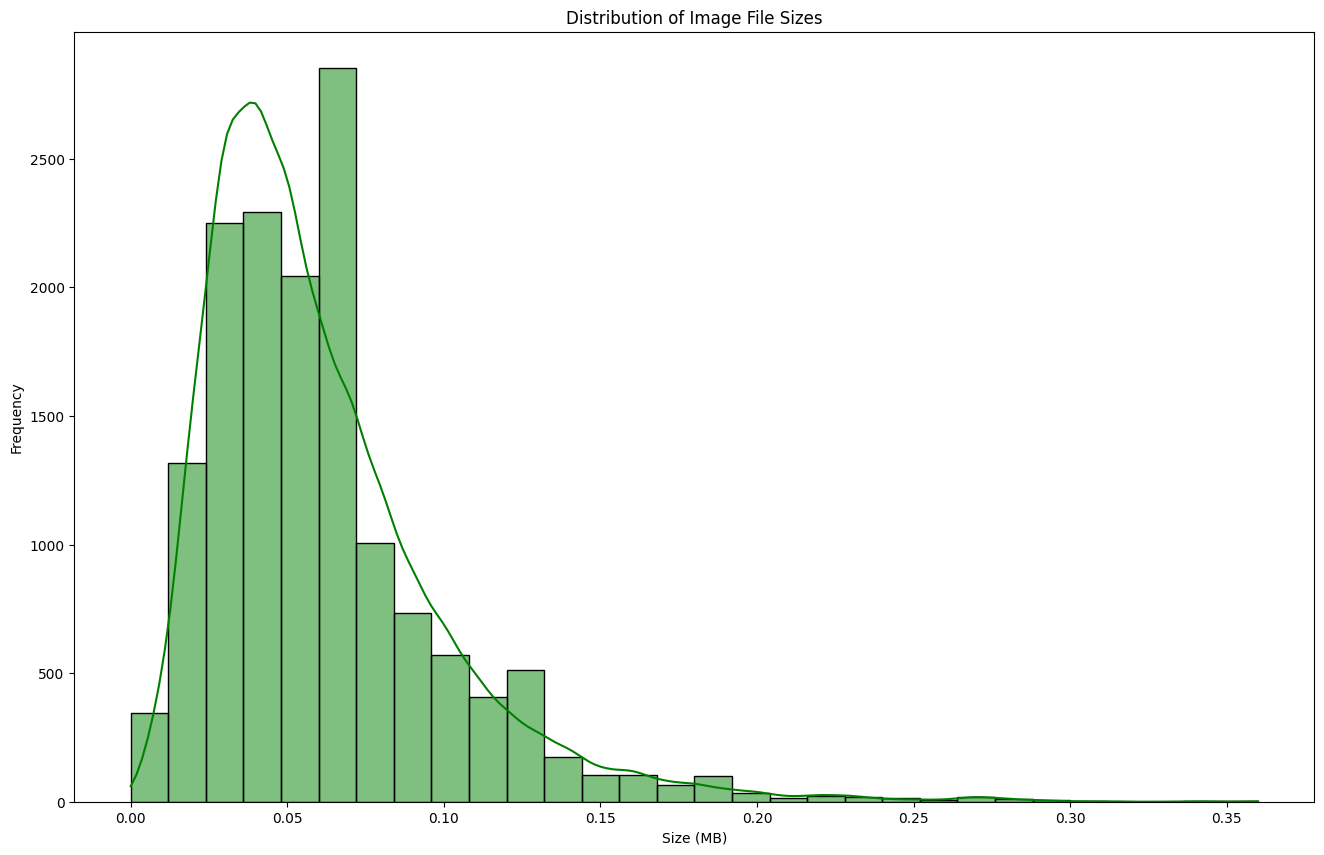

In [346]:
plt.figure(figsize=(16, 10))

# 이미지 파일의 크기 분포를 출력
sns.histplot(image_data['size'], bins=30, kde=True, color='green')
plt.title('Distribution of Image File Sizes')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')

plt.show()

이미지 파일 크기 분포
- 대부분 이미지 파일 크기는 0.05 ~ 0.1 MB 사이에 분포

### 2.1.2 이미지 파일크기 분석

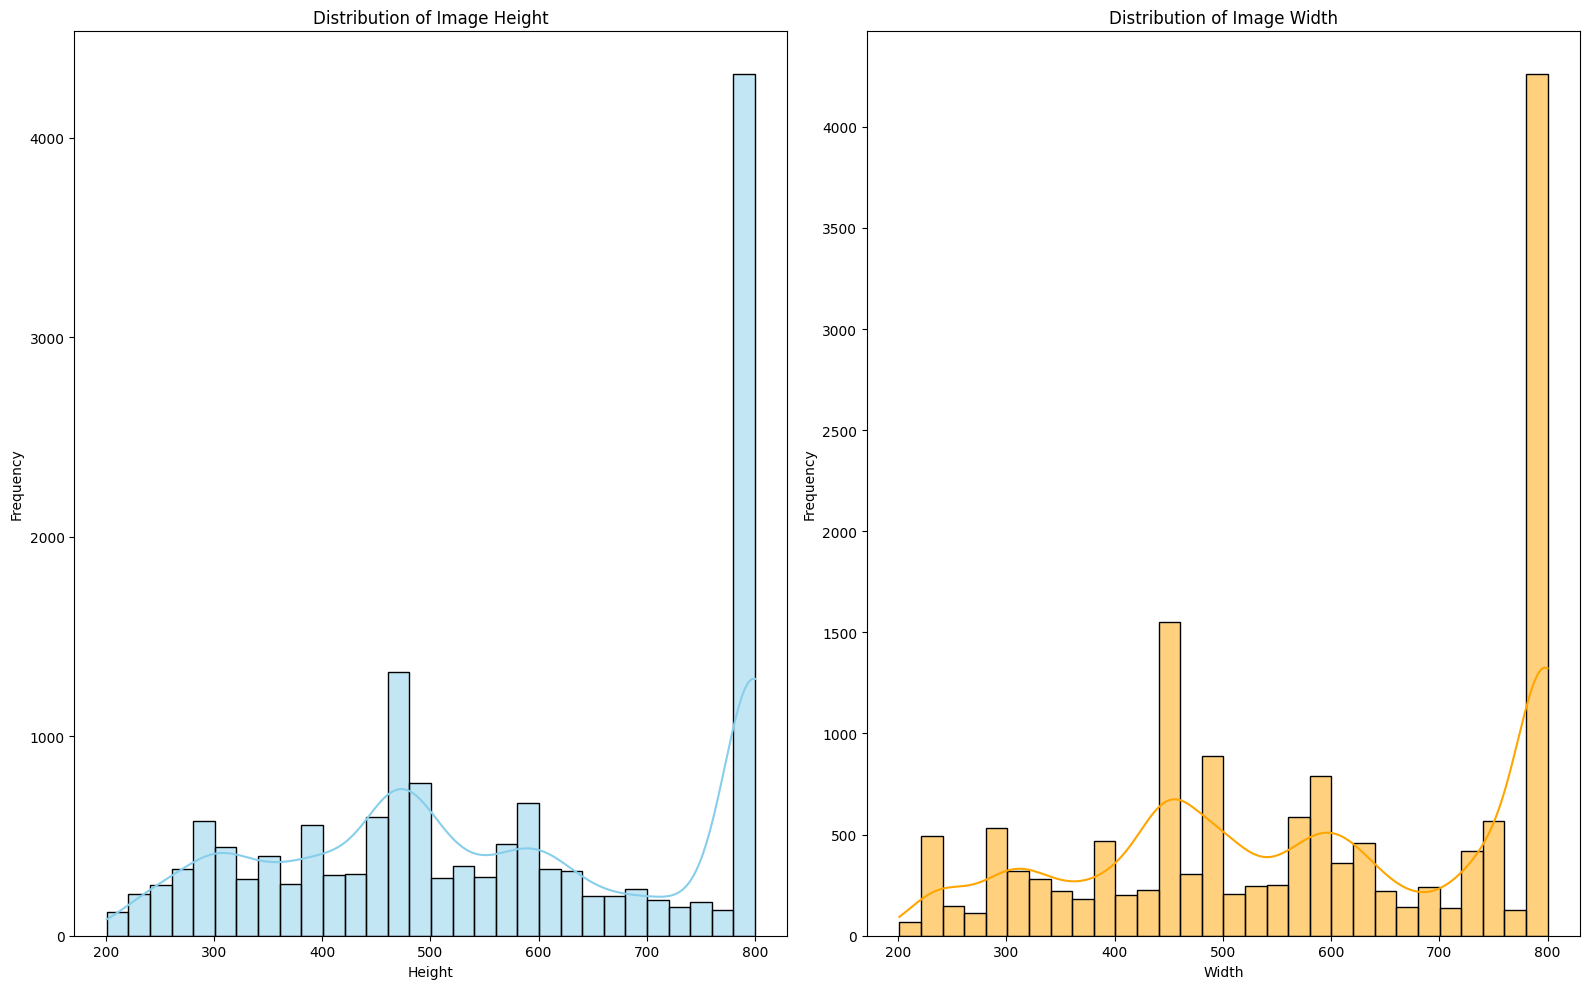

In [345]:
plt.figure(figsize=(16, 10))
# Image height의 분포를 출력
plt.subplot(1, 2, 1)
sns.histplot(image_data['height'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Image width의 분포를 출력
plt.subplot(1, 2, 2)
sns.histplot(image_data['width'], bins=30, kde=True, color='orange')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

이미지의 높이와 너비 분포
- 이미지 높이: 대부분 이미지 높이는 400에서 800 픽셀 사이에 분포
- 이미지 너비: 대부분 이미지 너비는 400에서 800 픽셀 사이에 분포

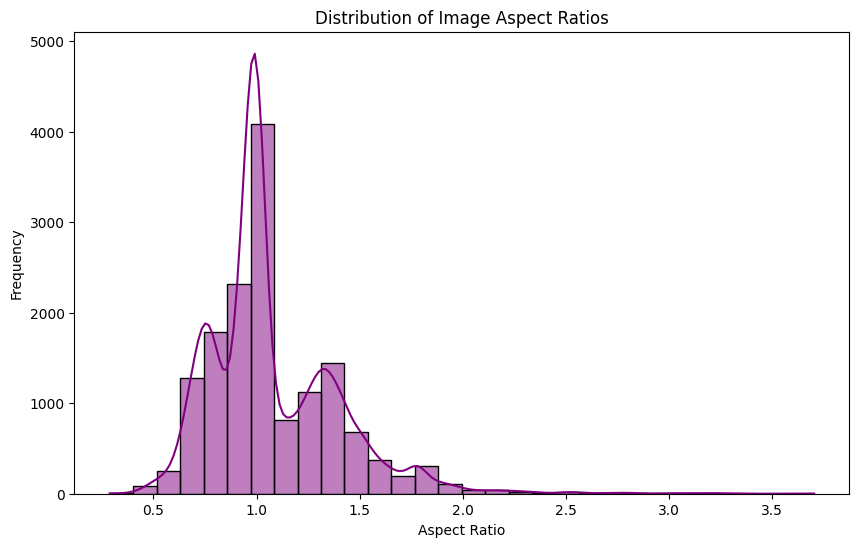

In [347]:
plt.figure(figsize=(10, 6))

# 이미지의 가로 세로 비율을 출력
sns.histplot(image_data['img_aspect_ratio'], bins=30, kde=True, color='purple')
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.show()


가로세로 비율 분포
- 대부분의 이미지 가로세로 비율을 0.8에서 1.2사이에 분포

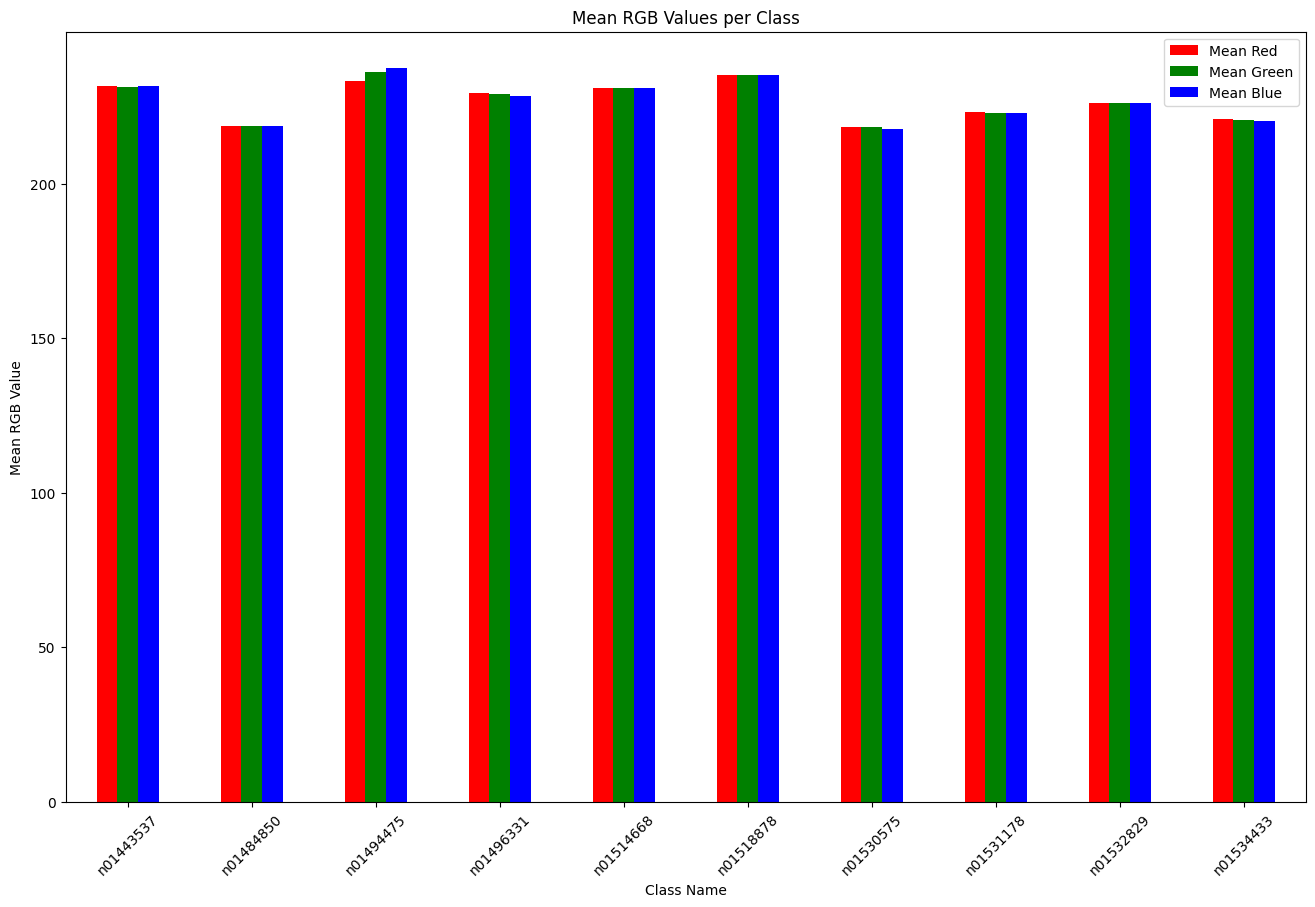

In [348]:
# 10개의 샘플 선택
sample_classes = image_data['class_name'].unique()[:10]

# 각 클래스별로 RGB값의 평균을 계산
mean_rgb_per_class = image_data[image_data['class_name'].isin(sample_classes)].groupby('class_name')[['mean_red', 'mean_green', 'mean_blue']].mean()

# 클래스별로 RGB값의 평균을 출력
mean_rgb_per_class.plot(kind='bar', figsize=(16, 10), color=['red', 'green', 'blue'])
plt.title('Mean RGB Values per Class')
plt.xlabel('Class Name')
plt.ylabel('Mean RGB Value')
plt.xticks(rotation=45)
plt.legend(['Mean Red', 'Mean Green', 'Mean Blue'])
plt.show()


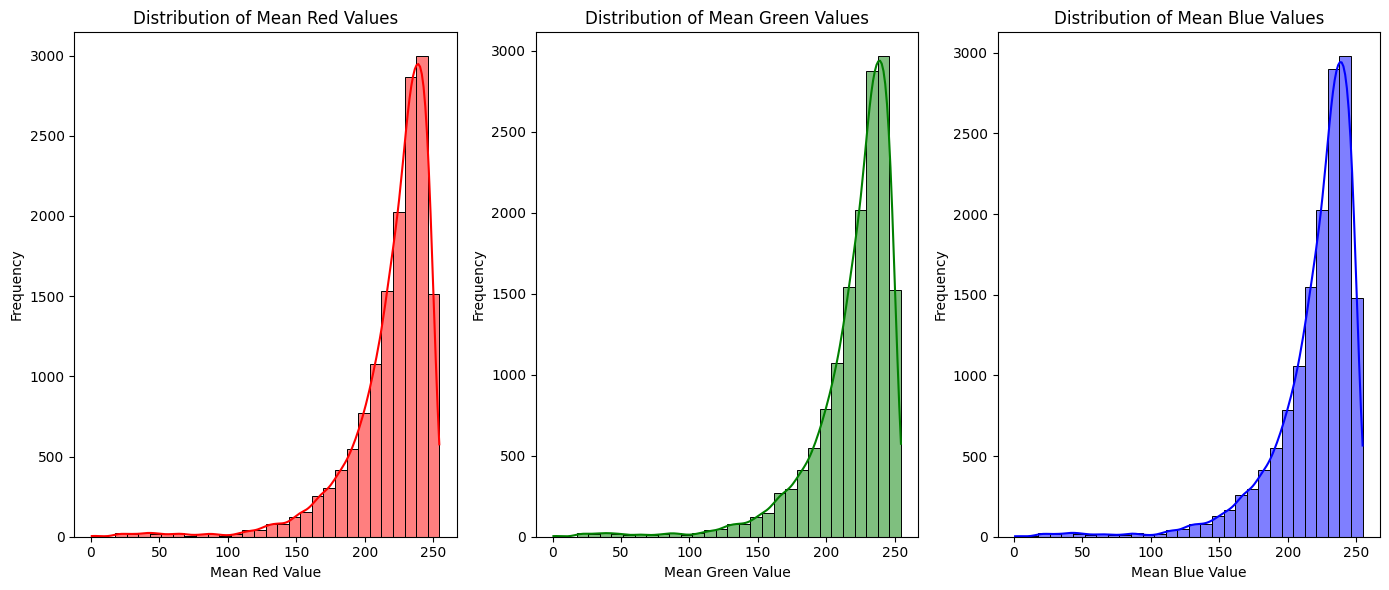

In [349]:
# RGB값의 평균 분포를 출력
plt.figure(figsize=(14, 6))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.histplot(image_data['mean_red'], bins=30, kde=True, color='red')
plt.title('Distribution of Mean Red Values')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.histplot(image_data['mean_green'], bins=30, kde=True, color='green')
plt.title('Distribution of Mean Green Values')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.histplot(image_data['mean_blue'], bins=30, kde=True, color='blue')
plt.title('Distribution of Mean Blue Values')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


색상 분포 분석
- 대부분 RGB, Green, Blue값이 200~250사이에 분포
- 전박적으로 이미지의 밝기와 채도가 높은 편

/var/folders/h6/61flrrfj1l38_nn873r977580000gn/T/ipykernel_38155/2640141684.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
/var/folders/h6/61flrrfj1l38_nn873r977580000gn/T/ipykernel_38155/2640141684.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')


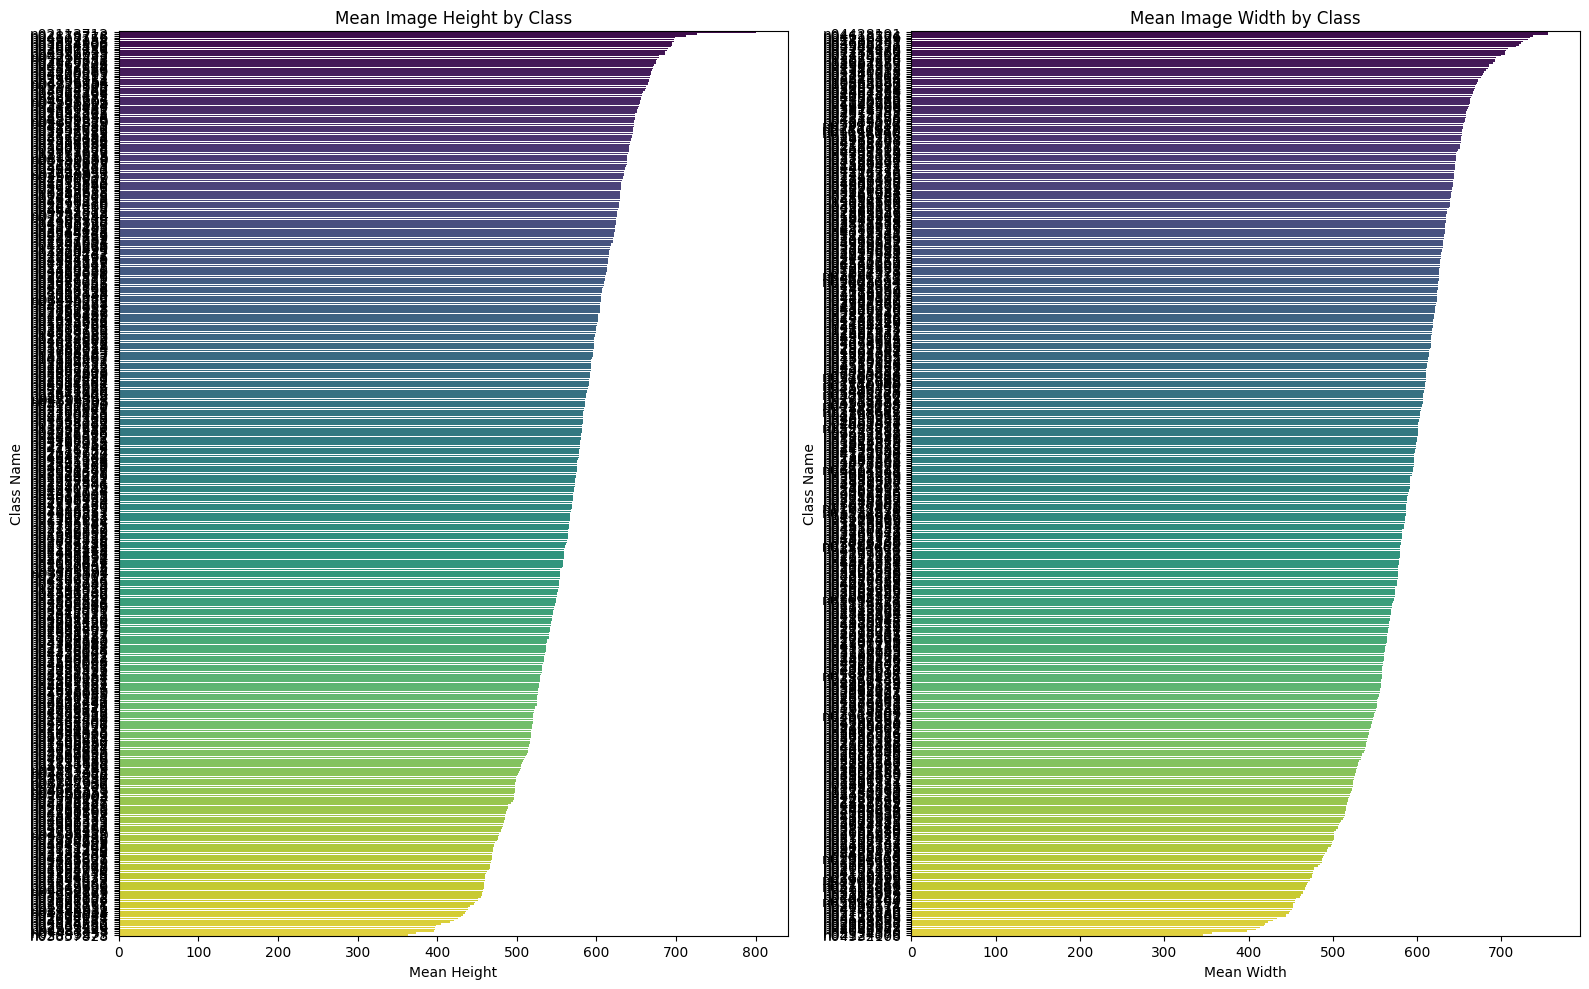

In [352]:
# 각 클래스별로 이미지의 평균 높이와 너비를 계산
class_size_stats = image_data.groupby('class_name')[['height', 'width']].mean().reset_index()

# 각 클래스별로 이미지의 평균 높이와 너비를 출력
plt.figure(figsize=(16, 10))

# 클래스별 이미지의 평균 높이를 출력
plt.subplot(1, 2, 1)
sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
plt.title('Mean Image Height by Class')
plt.xlabel('Mean Height')
plt.ylabel('Class Name')

# 클래스별 이미지의 평균 너비를 출력
plt.subplot(1, 2, 2)
sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')
plt.title('Mean Image Width by Class')
plt.xlabel('Mean Width')
plt.ylabel('Class Name')

plt.tight_layout()
plt.show()

클래스별 이미지 크기 분포
- 대부분 클래스는 300에서 800 픽셀 사이의 평균 높이를 가지고 있음
- 대부분 클래스느 300에서 800 픽셀 사이의 평균 너비를 가지고 있음

/var/folders/h6/61flrrfj1l38_nn873r977580000gn/T/ipykernel_38155/3931341571.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
/var/folders/h6/61flrrfj1l38_nn873r977580000gn/T/ipykernel_38155/3931341571.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
/var/folders/h6/61flrrfj1l38_nn873r977580000gn/T/ipykernel_38155/3931341571.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_blue', data=image_d

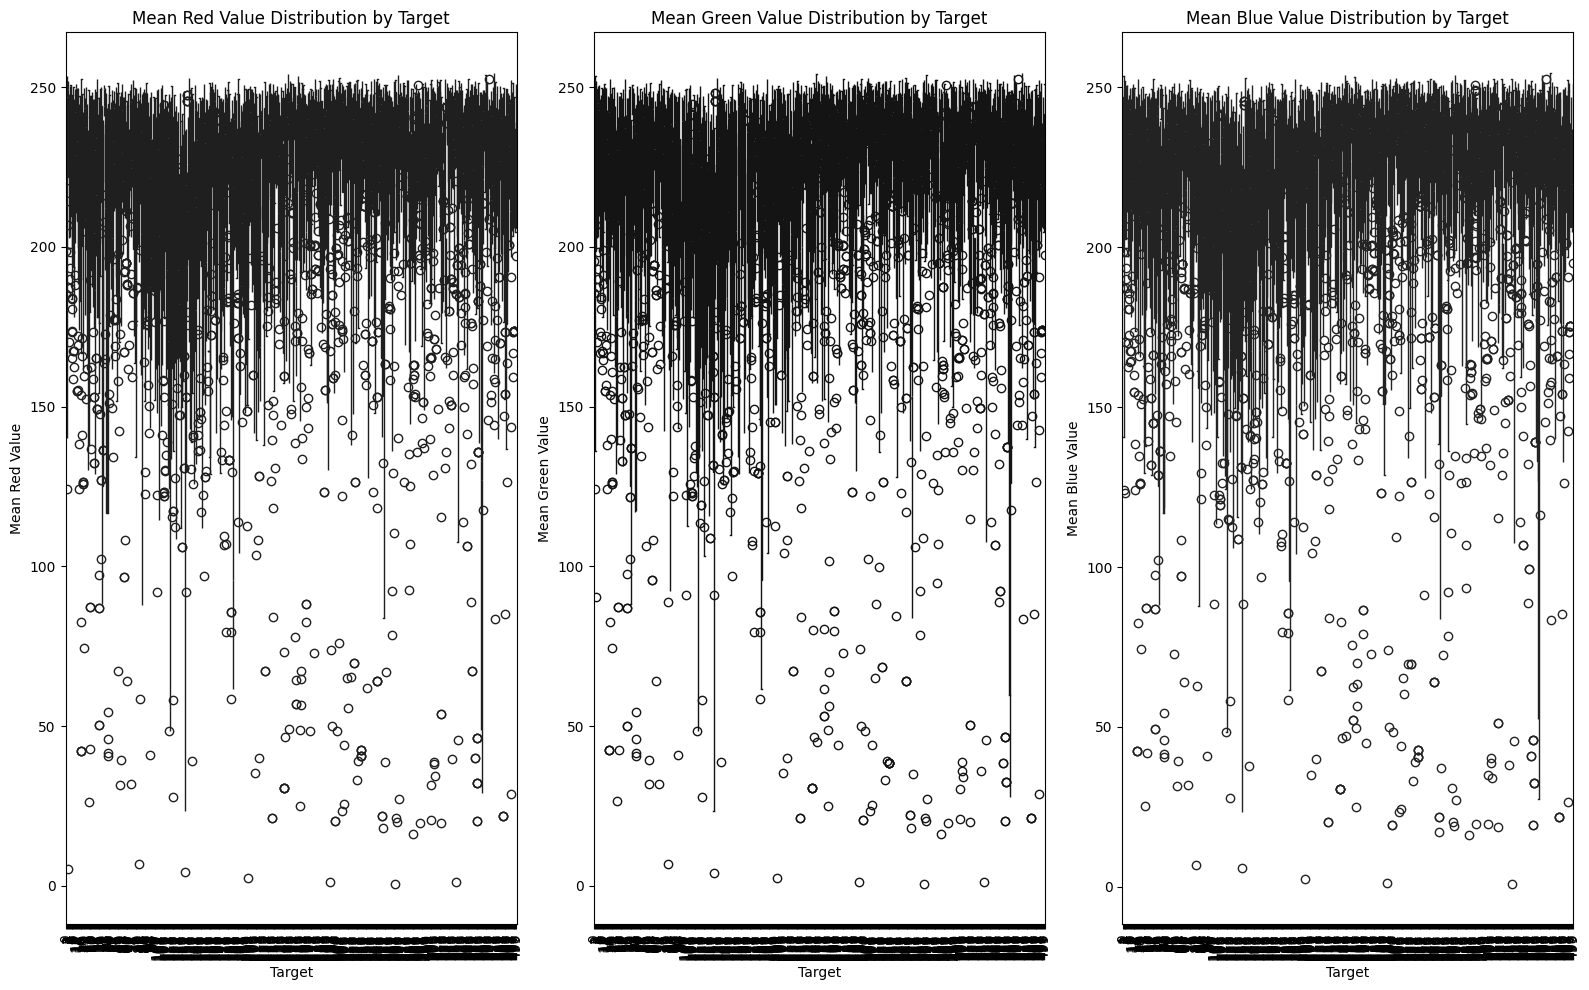

In [355]:
plt.figure(figsize=(16, 10))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
plt.title('Mean Red Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Red Value')
plt.xticks(rotation=90)

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
plt.title('Mean Green Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Green Value')
plt.xticks(rotation=90)

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='mean_blue', data=image_data, palette='Blues')
plt.title('Mean Blue Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Blue Value')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


클래스별 이미지 색상의 분포
- 대부분 Red, Green, Blue 값은 200에서 250 사이에 분포

## 2.2 Displaying images

In [19]:
image_data['target'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

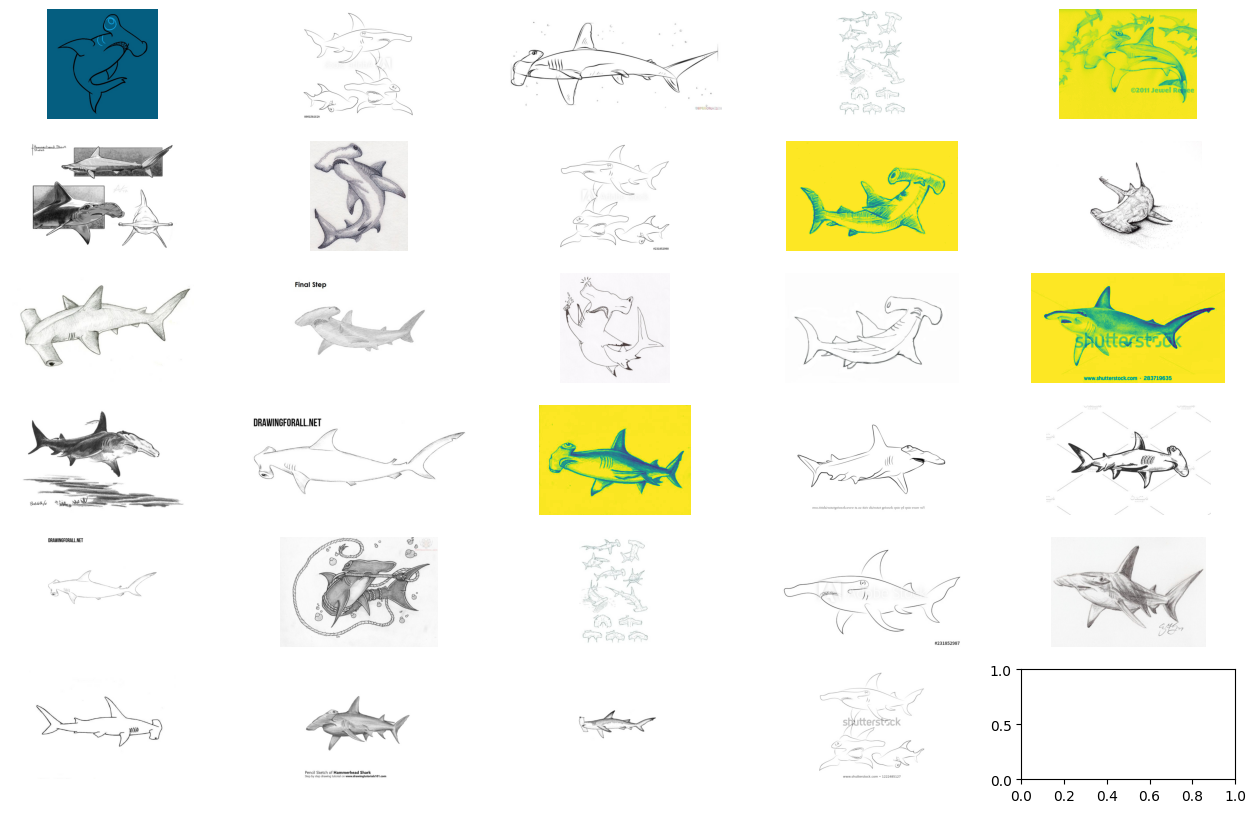

In [20]:
# 같은 target을 가진 이미지 전체 출력
def display_images(data, target):
    len_data = len(data[data['target'] == target])
    fig, axs = plt.subplots((len_data // 5)+1, 5, figsize=(16, 10))
    images = data[data['target'] == target]['path'].values
    for i, path in enumerate(images):
        img = Image.open(path)
        ax = axs[i // 5, i % 5]  # Use double indexing for 2D subplots
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# target이 0인 이미지 출력
display_images(image_data, target=2)

### 2.2.1 Displying random images using PIL

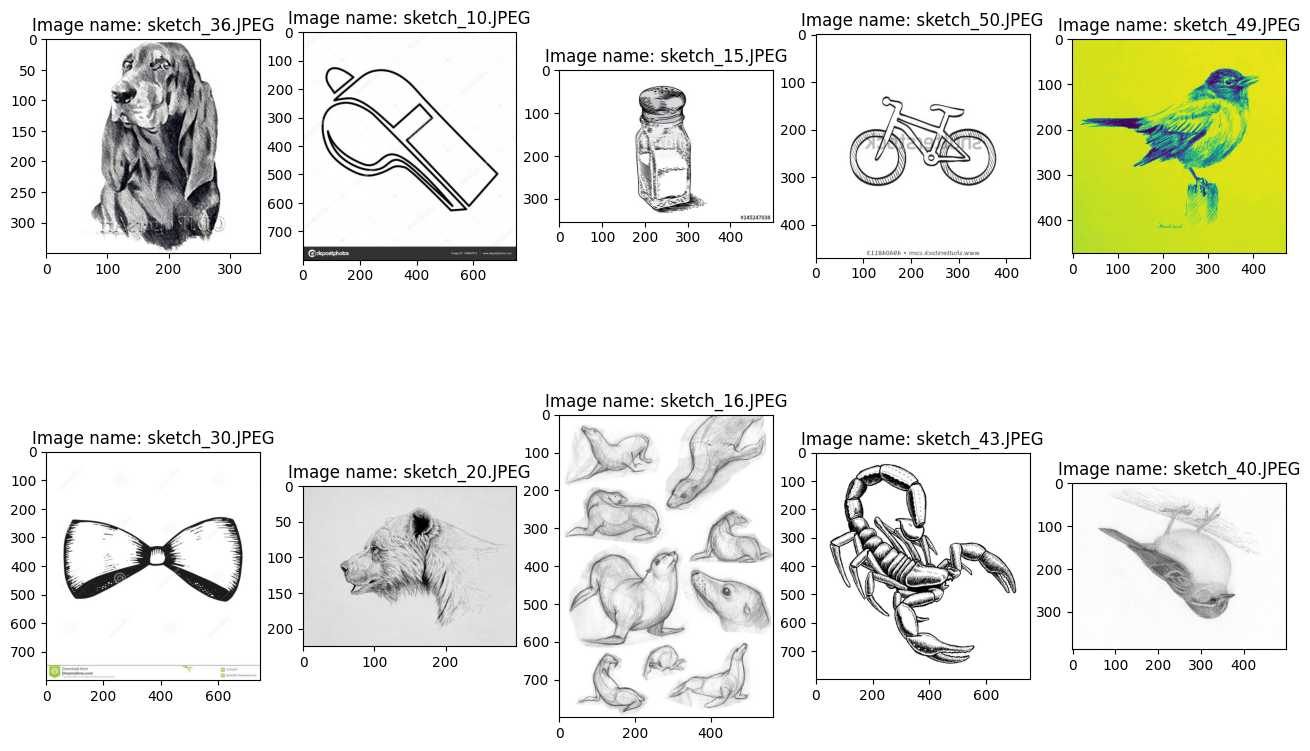

In [275]:
# 이미지를 랜덤으로 5개 출력
plt.style.use('default')
fig, axex = plt.subplots(2, 5, figsize=(16, 10))
for ax in axex.reshape(-1):
    img_path = np.random.choice(train_images)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Image name: {img_path.split('/')[-1]}")
plt.show()

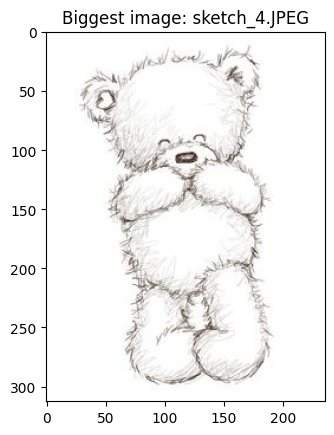

In [276]:
# 가장 큰 이미지를 출력
biggest_img_path = image_data.iloc[image_data['size'].idxmax(),:]['path']

img = Image.open(biggest_img_path)
plt.title(f"Biggest image: {biggest_img_path.split('/')[-1]}")
plt.imshow(img)
del img

In [277]:
# 4개의 작은 이미지를 출력
smallest_img_paths = image_data.nsmallest(4, 'size')['path']
smallest_img_paths.values

array(['./data/train/n04127249/sketch_9.JPEG',
       './data/train/n01484850/sketch_34.JPEG',
       './data/train/n01484850/sketch_0.JPEG',
       './data/train/n01494475/sketch_33.JPEG'], dtype=object)

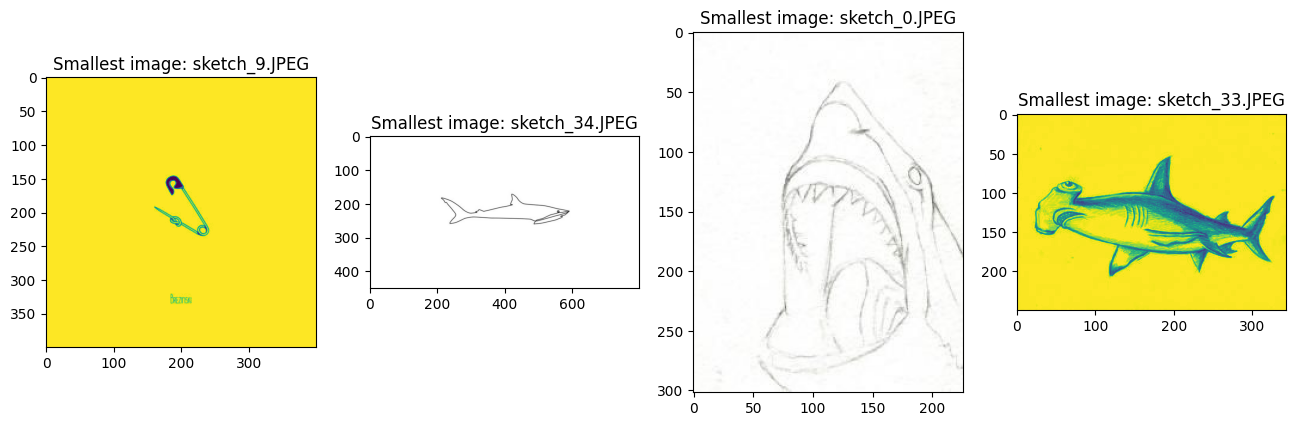

In [278]:
import matplotlib.image as mpimg

# 4개의 작은 이미지를 출력
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img = mpimg.imread(smallest_img_paths.values[i])
    ax.title.set_text(f"Smallest image: {smallest_img_paths.values[i].split('/')[-1]}")
    ax.imshow(img)
plt.show()

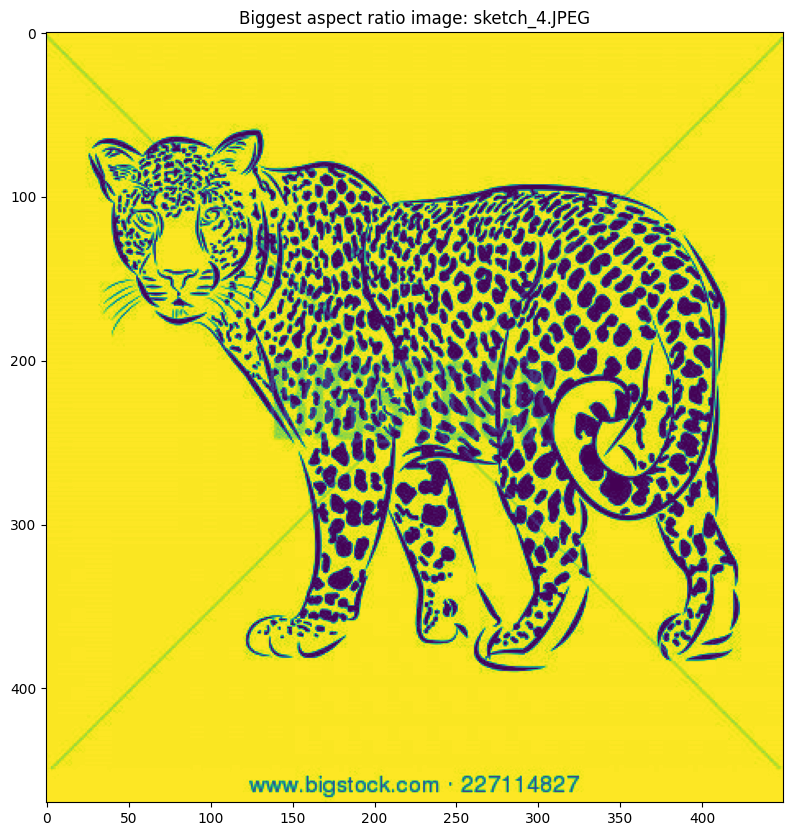

In [279]:
# 이미지의 종횡비가 가장 큰 이미지를 출력
biggest_aspect_ratio_img_path = image_data.iloc[image_data['img_aspect_ratio'].idxmax(),:]['path']

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
img = Image.open(biggest_aspect_ratio_img_path)
plt.title(f"Biggest aspect ratio image: {biggest_aspect_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

### 2.2.2 Diplaying, resizing and manipulation using CV2

In [280]:
img_path = train_images[10]
selected_img = image_data[image_data['path'] == img_path]
selected_img

height  width mode format  size class_name_x  \
10     800    752  RGB   JPEG   0.1    n02795169   

                                     path                image_path  \
10  ./data/train/n02795169/sketch_12.JPEG  n02795169/sketch_12.JPEG   

    img_aspect_ratio class_name_y  target  
10              0.94    n02795169     237

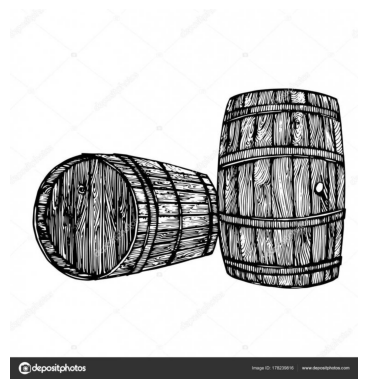

In [281]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

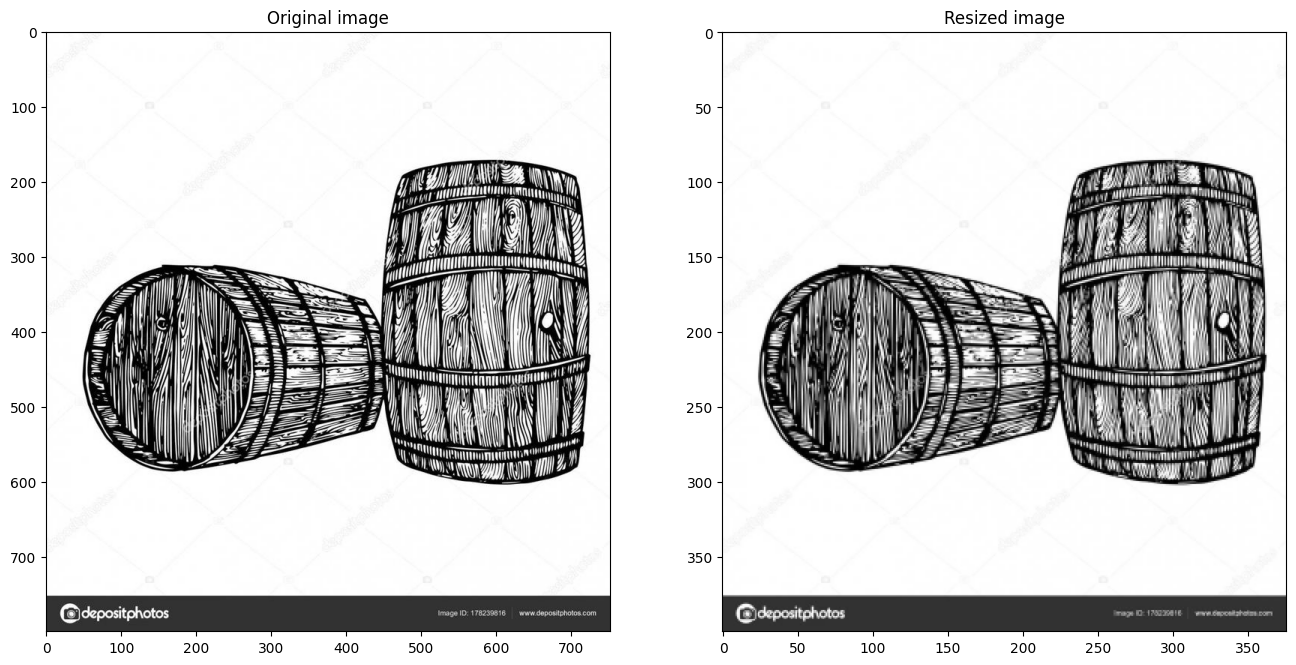

In [282]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(img)
ax[0].set_title("Original image")
ax[1].imshow(resized_img)
ax[1].set_title("Resized image")
plt.show()